# Stock Price Modelling Regression Experiment 1.0

Stock Price modelling - Experimentation Summary:

Build baseline models with default parameters. Then tune the same models. Evaluate their performance on Train/Valid/Test set. Save all models and their error performance.

# Modelling Regression Experiment #1.0

- Split data into Train / Validation / Test set
- Create Baseline Models
    - 1) Arima
        - Test for stationarity
        - Find p, q, d terms
        - Model Building
    - 2) Multivariate Arima
        - Causality investigation.
        - Test for stationary
        - Model Building.
        - Test for residuals (errors).
        - Forecasting
        - Model evaluation
    - 3) Random Forest
        - Baseline Model with Train set and evaluate on test set.
        - Model Tuning with Train set, select best parameters with Validation set and evaluate on test set
    - 4) XGBoost
        - Baseline Model with Train set and evaluate on test set.
        - Model Tuning with Train set, select best parameters with Validation set and evaluate on test set
    - 5) kNN
        - Baseline Model with Train set and evaluate on test set.
        - Model Tuning with Train set, select best parameters with Validation set and evaluate on test set
    - 6) SVM
        - Baseline Model with Train set and evaluate on test set.
        - Model Tuning with Train set, select best parameters with Validation set and evaluate on test set
    - 7) LSTM
        - Baseline Model with Train set and evaluate on test set.
        - Model Tuning with Train set, select best parameters with Validation set and evaluate on test set
- Compare their error performace

# Future Ideas / Work

Feature engineering with financial indicators

# 1 Install more libraries

Some libraries in remote Kaggle notebook are missing. They need to be installed 

In [ ]:
!pip install -q yfinance==0.2.28
!pip install -q pmdarima
# !pip install -q pandas_datareader

# 2 Loading the libraries

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O


# Suppress all warnings
import warnings
warnings.filterwarnings("ignore")

# plotting libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Sklearn libraries
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 3 Download stock data

In [12]:
def get_stock_data(stock_name):
    
    # For time stamps
    from datetime import datetime
    import yfinance as yf
    
    # The tech stocks we'll use for this analysis
    tech_list = [stock_name]

    dict_of_stocks = {}

    end = datetime.now()
    start = datetime(end.year - 16, end.month, end.day)

    for stock in tech_list:
        globals()[stock] = yf.download(stock, start, end)
        dict_of_stocks[tech_list[0]] = globals()[stock]
        

    return dict_of_stocks[tech_list[0]]

In [13]:
main_df = get_stock_data("KRI.AT")

[*********************100%%**********************]  1 of 1 completed


# 4 Inspecting the data

In [14]:
main_df.head(), main_df.tail()

(                Open      High       Low     Close  Adj Close  Volume
 Date                                                                 
 2007-10-29  2.301175  2.301175  2.216470  2.244705   1.603386   36125
 2007-10-30  2.216470  2.287058  2.202352  2.258822   1.613469   70125
 2007-10-31  2.216470  2.258822  2.216470  2.258822   1.613469   23516
 2007-11-01  2.258822  2.329411  2.230587  2.244705   1.603386   54395
 2007-11-02  2.230587  2.399999  2.230587  2.371764   1.694143  122683,
             Open  High   Low  Close  Adj Close  Volume
 Date                                                  
 2023-10-23  8.14  8.14  8.00   8.02       8.02    4617
 2023-10-24  8.04  8.20  8.00   8.18       8.18    6124
 2023-10-25  7.98  8.30  7.98   8.30       8.30    3615
 2023-10-26  8.18  8.22  8.08   8.20       8.20    6027
 2023-10-27  8.20  8.20  8.04   8.08       8.08    8081)

# 4-1 Performance dataframe for models' error/evaluation

In [26]:
df_default_model_rmse_performance = pd.DataFrame({
    'rmse': [np.NAN, np.NAN, np.NAN, np.NAN, np.NAN]
}, index=['rf', 'XGBoost', 'svm', 'kNN', 'LSTM'])


df_default_model_with_lagged_features_rmse_performance = pd.DataFrame({
    'rmse': [np.NAN, np.NAN, np.NAN, np.NAN, np.NAN]
}, index=['rf', 'XGBoost', 'svm', 'kNN', 'LSTM'])


df_tuned_model_with_lagged_features_rmse_performance = pd.DataFrame({
    'rmse': [np.NAN, np.NAN, np.NAN, np.NAN, np.NAN, np.NAN, np.NAN]
}, index=['Arima', 'VAR', 'rf_tuned', 'XGBoost_tuned', 'svm_tuned', 'kNN_tuned', 'LSTM_tuned'])

# 4-2 Dataset timestamps

In [58]:
#Experiment_1


train_start_time = '2016-01-01'
train_end_time = '2020-12-31' 

validation_start_time = '2021-01-01'
validation_end_time = '2022-12-31'

test_start_time = '2023-01-01'
test_end_time = str(main_df.index[-1].year)+"-"+str(main_df.index[-1].month)+"-"+str(main_df.index[-1].day)



#Experiment_2
""" 
train_start_time = '2020-01-01'
train_end_time = '2022-12-31' 

validation_start_time = '2023-01-01'
validation_end_time = '2023-09-30'

test_start_time = '2023-10-01'
 """

#Experiment_3
""" 
train_start_time = '2018-01-01'
train_end_time = '2022-12-31' 

validation_start_time = '2023-01-01'
validation_end_time = '2023-09-30'

test_start_time = '2023-10-01' 
 """

#Experiment_4
""" 
train_start_time = str(main_df.index[0].year)+"-"+str(main_df.index[0].month)+"-"+str(main_df.index[0].day)
train_end_time = '2022-12-31' 

validation_start_time = '2023-01-01'
validation_end_time = '2023-09-30'

test_start_time = '2023-10-01' 
 """

' \ntrain_start_time = str(main_df.index[0].year)+"-"+str(main_df.index[0].month)+"-"+str(main_df.index[0].day)\ntrain_end_time = \'2022-12-31\' \n\nvalidation_start_time = \'2023-01-01\'\nvalidation_end_time = \'2023-09-30\'\n\ntest_start_time = \'2023-10-01\' \n '

# 5 Statistical Learning - Time Series

In [133]:
def split_dataset_for_arima(main_df, 
                            train_start = '2020-01-01',
                            train_end = '2022-12-31', 
                            validation_start = '2023-01-01',
                            validation_end = '2023-08-31',
                            test_start = '2023-09-01',
                            test_end = '2023-09-30'):


    # Split the data into train, validation, and test sets
    train_set = main_df[(main_df.index >= train_start) & (main_df.index <= train_end)]
    validation_set = main_df[(main_df.index >= validation_start) & (main_df.index <= validation_end)]
    train_and_validation_set = pd.concat([train_set, validation_set], axis=0)
    test_set = main_df[(main_df.index >= test_start) & (main_df.index <= test_end)]


    # Print the sizes of the sets
    print("Train Set Size:", len(train_set))
    print("Validation Set Size:", len(validation_set))
    print("Test Set Size:", len(test_set))

    return train_set, validation_set, train_and_validation_set, test_set

# 5-1. Spliting the dataset for Arima model

In [134]:
train_set, validation_set, train_and_validation_set, test_set = split_dataset_for_arima(main_df, 
                                    train_start = train_start_time,
                                    train_end = train_end_time, 
                                    validation_start = validation_start_time,
                                    validation_end = validation_end_time,
                                    test_start = test_start_time,
                                    test_end = test_end_time)

Train Set Size: 1245
Validation Set Size: 497
Test Set Size: 206


# 6 Arima model

# 6.1 Sources/tutorials

https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

# 6.2 Dickey Fuller Test

In [135]:
def dickey_fuller_test(df):

    from statsmodels.tsa.stattools import adfuller
    from numpy import log
    result = adfuller(df.Close.dropna())
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

dickey_fuller_test(train_set)

ADF Statistic: -0.141388
p-value: 0.945157


If the p-value is less than a significance level (e.g. 0.05), you can reject the null hypothesis, indicating that the time series is stationary.

If the p-value is greater than the significance level, you fail to reject the null hypothesis, suggesting that the time series is non-stationary.

The p-value is 0.608091, which is greater than the common significance level of 0.05. Therefore, based on this ADF test, you fail to reject the null hypothesis, suggesting that your time series is likely non-stationary. Non-stationary time series often exhibit trends, seasonality, or other patterns that change over time.

# 6-3 How to find the order of differencing (d) in ARIMA model

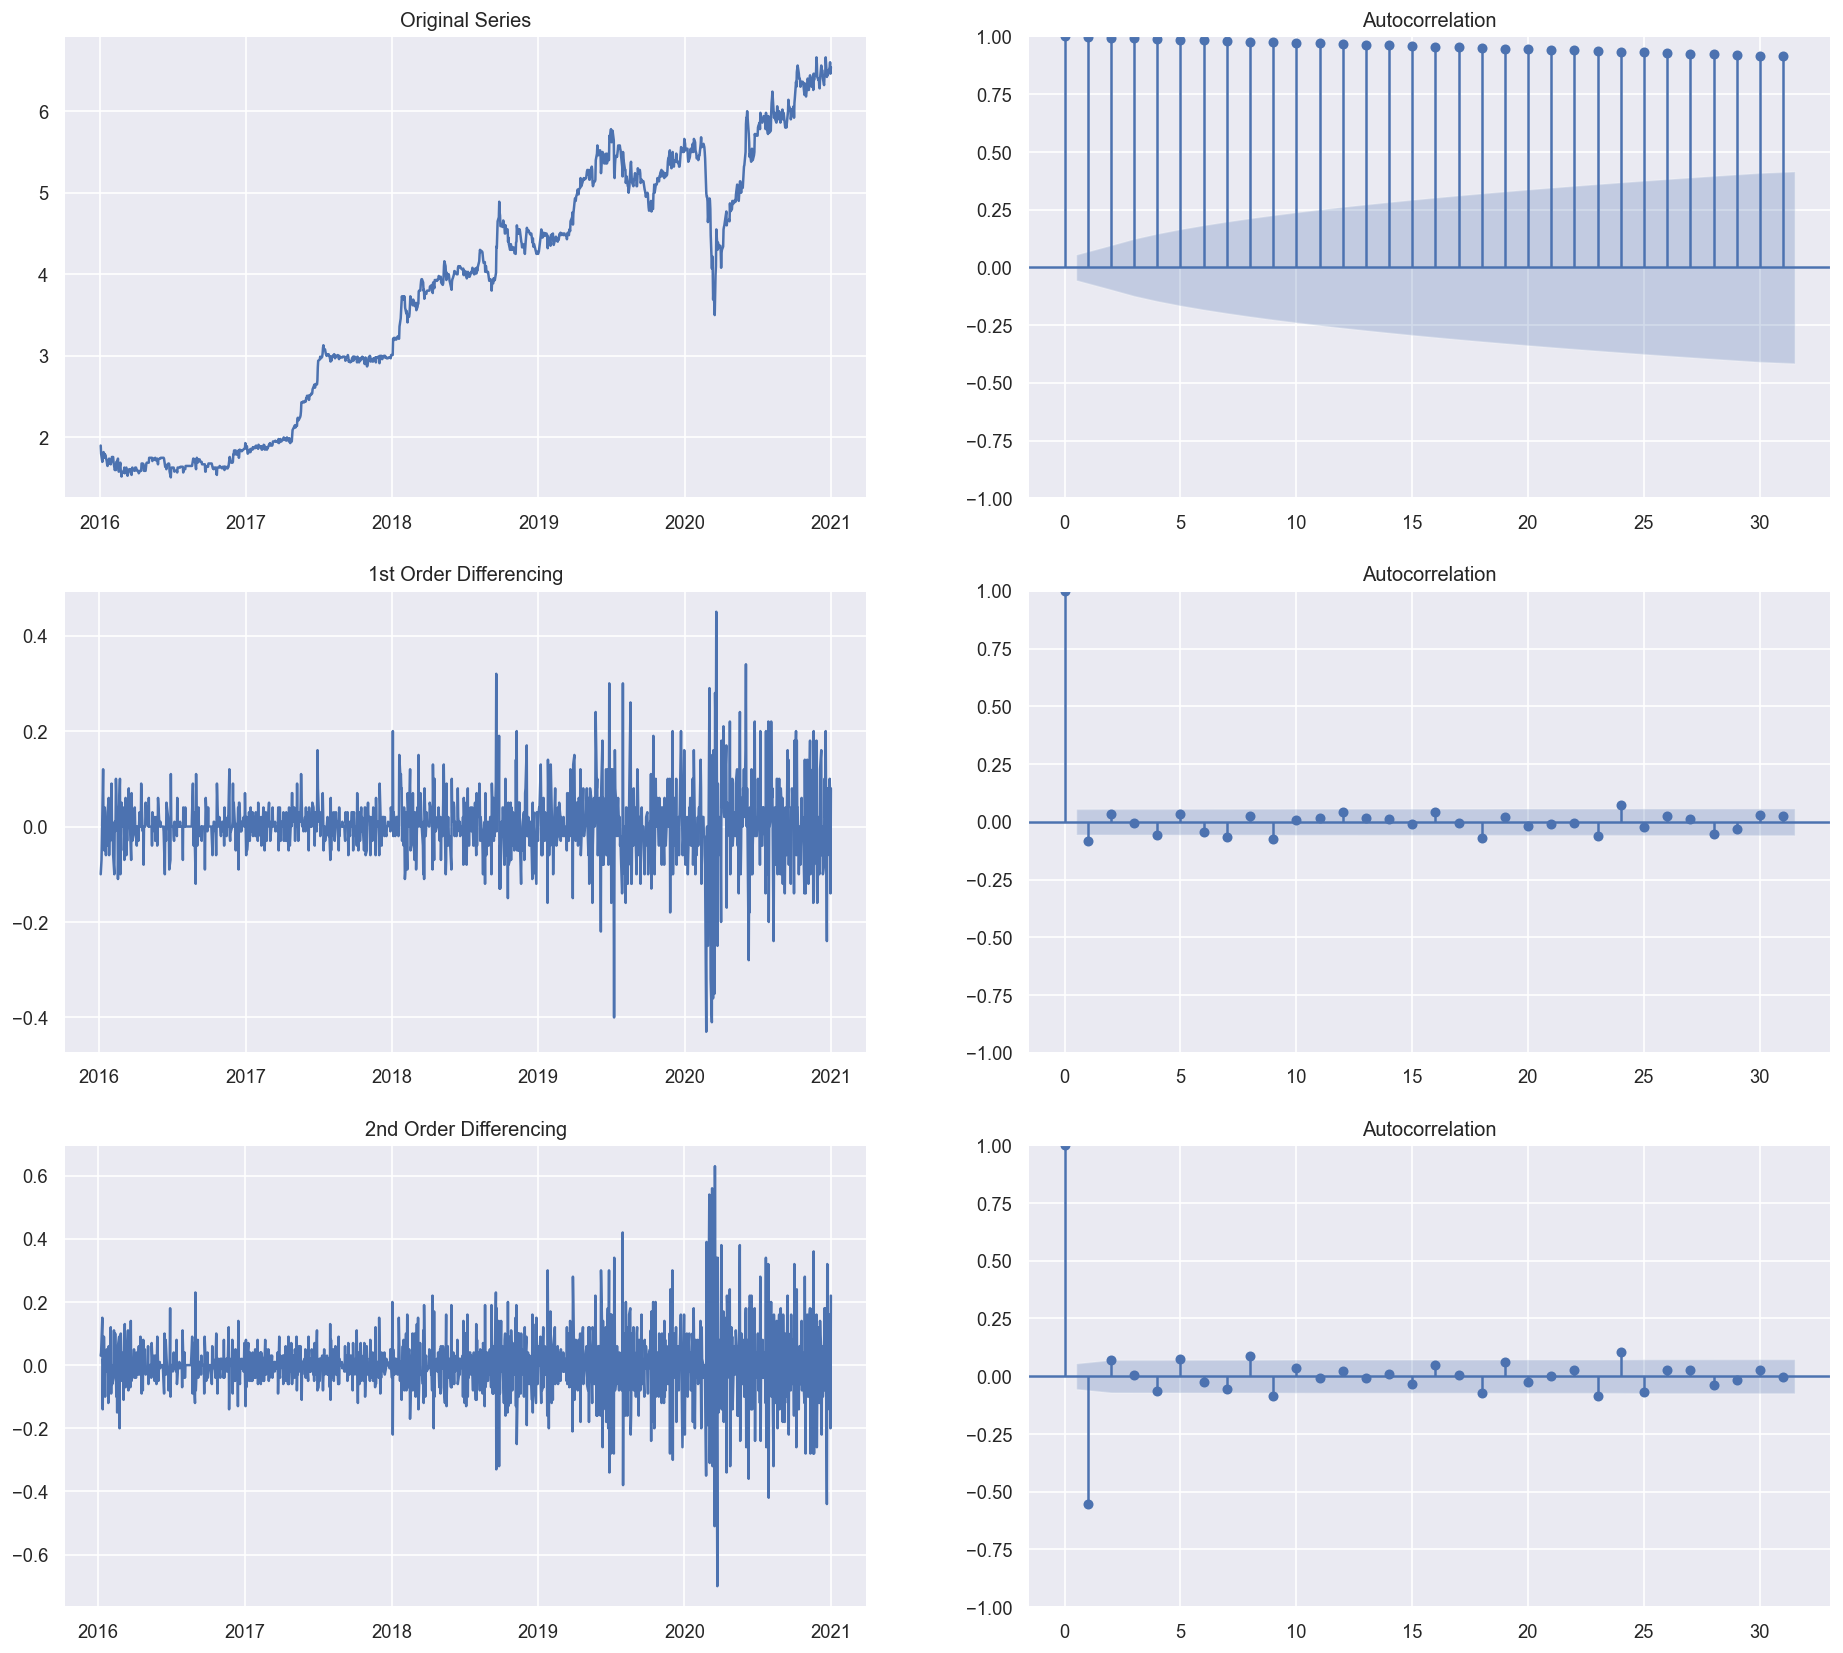

In [136]:
def autocorrelation_plots(df):

    from statsmodels.graphics.tsaplots import plot_acf
    plt.rcParams.update({'figure.figsize':(19,17), 'figure.dpi':120})

    # Original Series
    fig, axes = plt.subplots(3, 2)
    axes[0, 0].plot(df.Close); axes[0, 0].set_title('Original Series')
    plot_acf(df.Close, ax=axes[0, 1])

    # 1st Differencing
    axes[1, 0].plot(df.Close.diff()); axes[1, 0].set_title('1st Order Differencing')
    plot_acf(df.Close.diff().dropna(), ax=axes[1, 1])

    # 2nd Differencing
    axes[2, 0].plot(df.Close.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
    plot_acf(df.Close.diff().diff().dropna(), ax=axes[2, 1])

    plt.show()

autocorrelation_plots(train_set)

# 6-4 Adf Test - KPSS test - PP test

In [137]:
from pmdarima.arima.utils import ndiffs

## Adf Test
adf = ndiffs(train_set.Close, test='adf')  # 1

# KPSS test
kpss = ndiffs(train_set.Close, test='kpss')  # 1

# PP test:
pp = ndiffs(train_set.Close, test='pp')  # 1

adf, kpss, pp

(1, 1, 0)

# 6-5 PACF plot

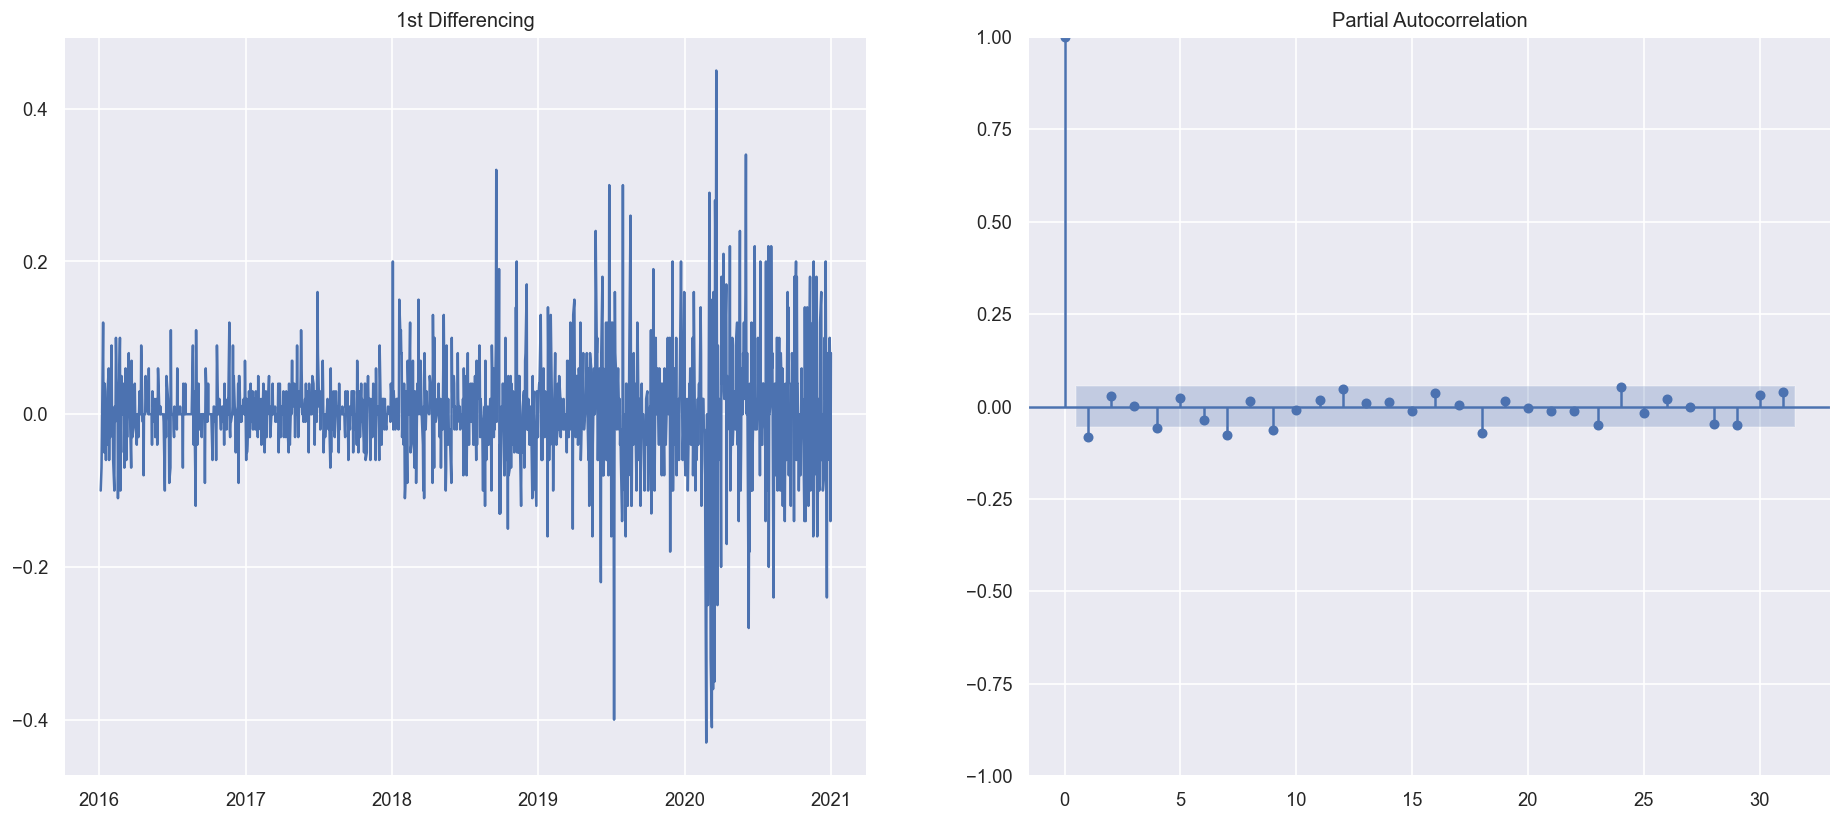

In [138]:
def partial_autocorrelation_plots(df):

    from statsmodels.graphics.tsaplots import plot_pacf

    # PACF plot of 1st differenced series
    plt.rcParams.update({'figure.figsize':(19,8), 'figure.dpi':120})

    fig, axes = plt.subplots(1, 2)
    axes[0].plot(df.Close.diff()); axes[0].set_title('1st Differencing')
    axes[1].set(ylim=(0,5))
    plot_pacf(df.Close.diff().dropna(), ax=axes[1])

    plt.show()

partial_autocorrelation_plots(train_set)

# 6-6 Auto Arima to find the best parameters

find the optimal p, q, d orders

source / tutorial at:
https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html

In [139]:
def auto_arima(df):

     import pmdarima as pm

     auto_arima_model = pm.auto_arima(df['Close'], start_p=1, d=None, start_q=1, max_p=5, max_d=2, max_q=5, start_P=1, D=None, start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=5, m=1, seasonal=True, stationary=False,error_action='ignore',  
                              suppress_warnings=True,
                         stepwise=True, trace=True)
     
     return auto_arima_model

auto_arima_model = auto_arima(train_set)

          

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2934.303, Time=1.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2929.400, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2935.633, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2935.162, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2928.280, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-2934.581, Time=0.63 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-2932.579, Time=1.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-2933.968, Time=0.33 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 4.289 seconds


# 6-7 Build Arima model after finding AutoArima parameters

After using AutoArima, lets build the Arima model using statsmodels library

c:\Users\praxitelis\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\praxitelis\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\praxitelis\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  207
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 158.122
Date:                Sun, 29 Oct 2023   AIC                           -312.244
Time:                        07:50:14   BIC                           -305.589
Sample:                             0   HQIC                          -309.552
                                - 207                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0260      0.060     -0.437      0.662      -0.143       0.091
sigma2         0.0126      0.001     18.590      0.000       0.011       0.014
Ljung-Box (L1) (Q):                   0.01   Jarque-

<Figure size 2280x960 with 0 Axes>

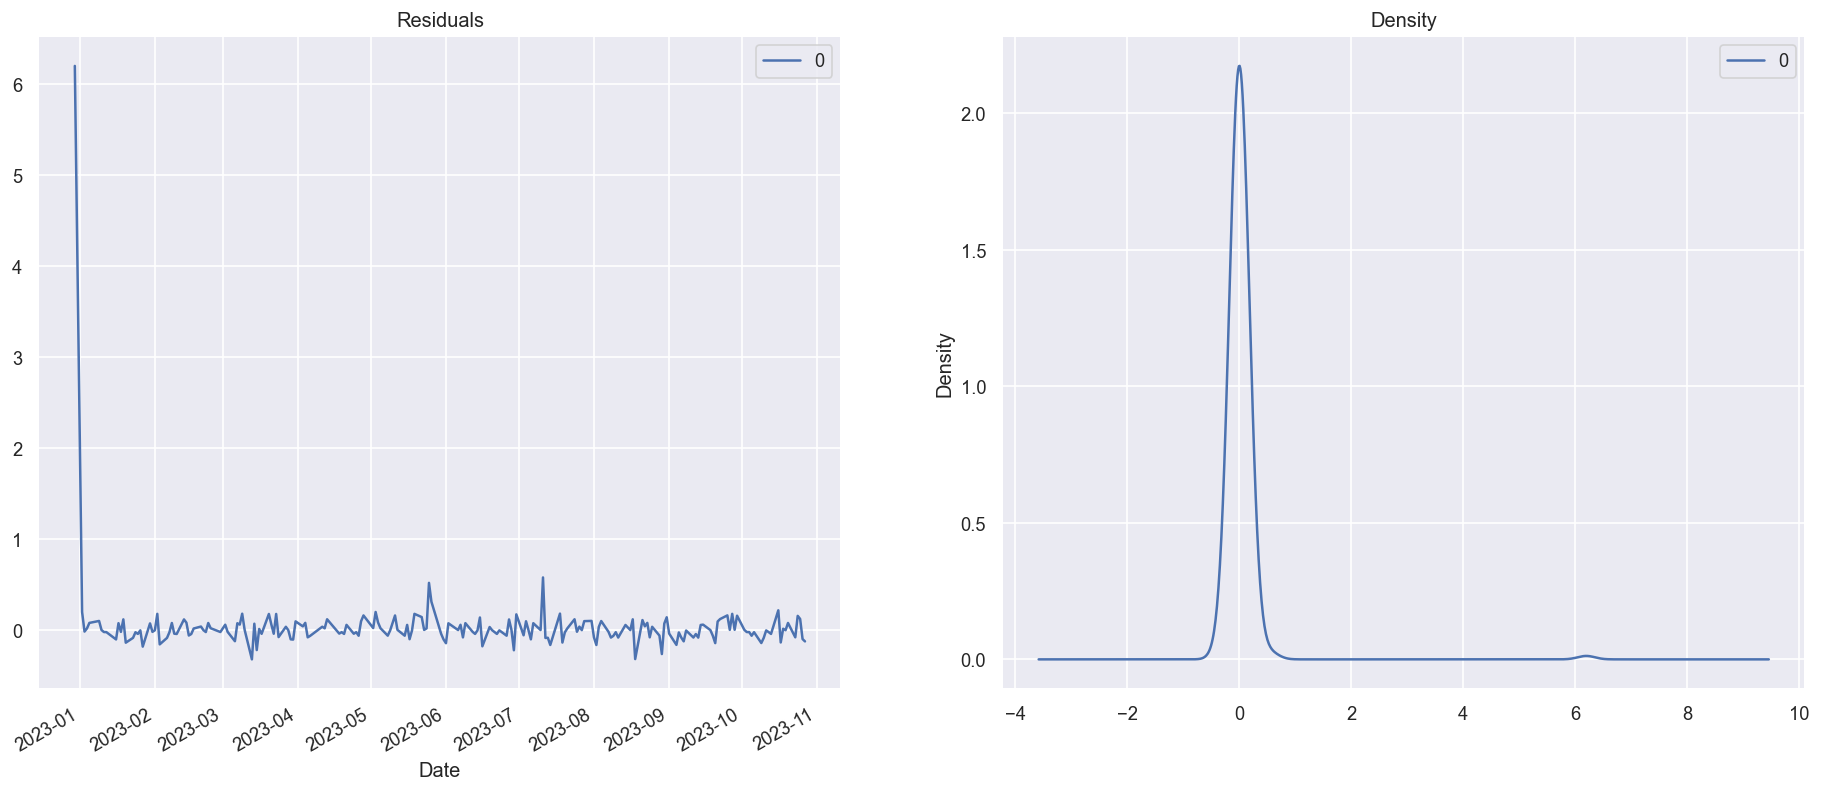

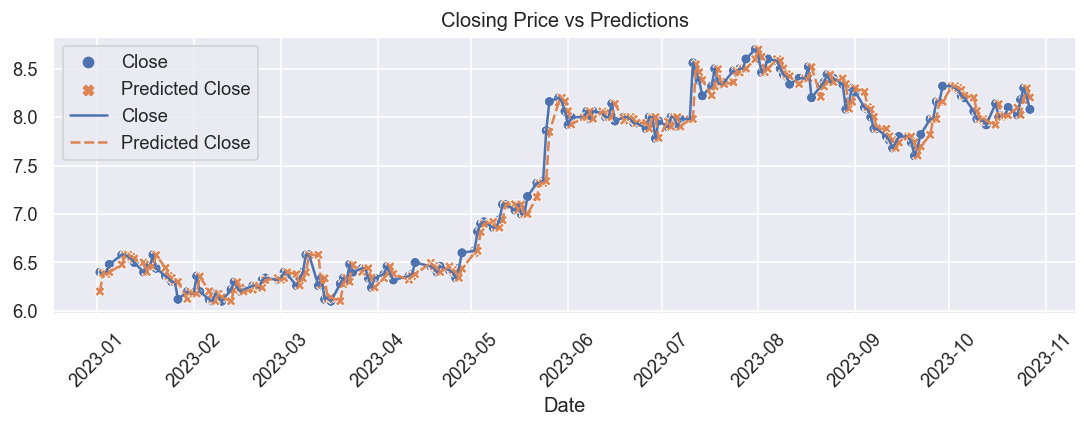

In [140]:
def build_arima_model(auto_arima_model, test_set):

    from statsmodels.tsa.arima.model import ARIMA

    # Fit the ARIMA model into the test set
    df = pd.concat([validation_set[-1:], test_set])

    arima_model = ARIMA(df['Close'], order=(auto_arima_model.order[0], 
                                            auto_arima_model.order[1], 
                                            auto_arima_model.order[2]))


    arima_model_res = arima_model.fit()
    print(arima_model_res.summary())


    # create forecasts
    forecasts =  arima_model_res.predict(start=1, end=len(test_set))

    # evaluate forecasts against test_set
    from sklearn.metrics import mean_squared_error

    mse = mean_squared_error(test_set['Close'], forecasts)
    rmse = np.sqrt(mse)
    print(f"Root Mean Squared Error (RMSE): {rmse}")

    # Plot residual errors
    residuals = pd.DataFrame(arima_model_res.resid)
    plt.figure()
    fig, ax = plt.subplots(1,2)
    residuals.plot(title="Residuals", ax=ax[0])
    residuals.plot(kind='kde', title='Density', ax=ax[1])
    plt.show()


    #plot Close and predicted Close price
    plot_df = pd.DataFrame({'Date': test_set.index,
                        'Close': test_set['Close'],
                        'Predicted Close': forecasts
                            })


    my_plot = sns.set(rc={'figure.figsize':(11, 3)})
    plt.figure()
    my_plot = sns.scatterplot(plot_df)
    my_plot = sns.lineplot(plot_df)
    my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45)
    my_plot.set(title='Closing Price vs Predictions')

    df_default_model_with_lagged_features_rmse_performance.loc['Arima'] = rmse
    df_tuned_model_with_lagged_features_rmse_performance.loc['Arima'] = rmse


    return arima_model, rmse

arima_model, arima_rmse = build_arima_model(auto_arima_model, test_set)

# 7 Multivariate Time Series


Tutorial / Source:

https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

https://blogs.sap.com/2021/05/06/a-multivariate-time-series-modeling-and-forecasting-guide-with-python-machine-learning-client-for-sap-hana/

https://mlpills.dev/time-series/step-by-step-guide-to-multivariate-time-series-forecasting-with-var-models/

https://towardsdatascience.com/a-quick-introduction-on-granger-causality-testing-for-time-series-analysis-7113dc9420d2#:~:text=The%20Granger%20causality%20test%20is,predict%20tomorrow's%20Tesla's%20stock%20price%3F

# 7-1 Test for causation amongst the time series 

Granger Causality tests

In [141]:
def test_for_causation(train_set):

    from statsmodels.tsa.stattools import grangercausalitytests

    maxlag = 20
    variables=train_set.columns
    matrix = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for col in matrix.columns:
        for row in matrix.index:
            test_result = grangercausalitytests(train_set[[row, col]], maxlag=20, verbose=False)
            p_values = [round(test_result[i+1][0]['ssr_chi2test'][1],4) for i in range(maxlag)]
            min_p_value = np.min(p_values)
            matrix.loc[row, col] = min_p_value
    matrix.columns = [var + '_x' for var in variables]
    matrix.index = [var + '_y' for var in variables]
    print(matrix)

test_for_causation(train_set)

             Open_x  High_x   Low_x  Close_x  Adj Close_x  Volume_x   sma_x  \
Open_y       1.0000  0.0000  0.0000   0.0000       0.0000    0.0001  0.0000   
High_y       0.0239  1.0000  0.0000   0.0000       0.0000    0.3683  0.0000   
Low_y        0.0089  0.0000  1.0000   0.0000       0.0000    0.0001  0.0000   
Close_y      0.0000  0.0013  0.0006   1.0000       0.1687    0.0863  0.0085   
Adj Close_y  0.0000  0.0017  0.0019   0.2591       1.0000    0.1049  0.0090   
Volume_y     0.0000  0.0000  0.0000   0.0000       0.0000    1.0000  0.0000   
sma_y        0.0000  0.0000  0.0000   0.0000       0.0000    0.0000  1.0000   
wma_y        0.0000  0.0000  0.0000   0.0000       0.0000    0.0000  0.0000   
mom_y        0.0000  0.0000  0.0000   0.0000       0.0000    0.1325  0.0000   
stoch_k_y    0.0000  0.0000  0.0000   0.0000       0.0000    0.4651  0.0000   
stoch_d_y    0.0000  0.0000  0.0000   0.0000       0.0000    0.1171  0.0000   
rsi_y        0.0955  0.0196  0.1144   0.0594       0

From the result above, each column represents a predictor x of each variable and each row represents the response y and the p-value of each pair of variables are shown in the matrix.

The row are the response (y) and the columns are the predictors (x). If a given p-value is < significance level (0.05), we can reject the null hypothesis and conclude that Open_x Granger causes High_y.

# 7-2 Test for stationarity -  Ad fuller test

In [142]:
def test_for_stationarity(train_set):

    from statsmodels.tsa.stattools import adfuller

    def adfuller_test(df, series, sig=0.05):
        res = adfuller(df[series], autolag='AIC')    
        p_value = round(res[1], 3)
        
        if p_value <= sig:
            print(f" {series} : P-Value = {p_value} => Stationary. ")
        else:
            print(f" {series} : P-Value = {p_value} => Non-stationary.")

    for column in train_set.columns:
        adfuller_test(train_set, column)

test_for_stationarity(train_set)

 Open : P-Value = 0.936 => Non-stationary.
 High : P-Value = 0.938 => Non-stationary.
 Low : P-Value = 0.928 => Non-stationary.
 Close : P-Value = 0.945 => Non-stationary.
 Adj Close : P-Value = 0.967 => Non-stationary.
 Volume : P-Value = 0.0 => Stationary. 
 sma : P-Value = 0.937 => Non-stationary.
 wma : P-Value = 0.93 => Non-stationary.
 mom : P-Value = 0.0 => Stationary. 
 stoch_k : P-Value = 0.0 => Stationary. 
 stoch_d : P-Value = 0.0 => Stationary. 
 rsi : P-Value = 0.0 => Stationary. 
 macd : P-Value = 0.0 => Stationary. 
 willr : P-Value = 0.0 => Stationary. 
 adosc : P-Value = 0.0 => Stationary. 


# 7-3 Transform the series to make it stationary, if needed

In [143]:
def adfuller_test(df, series, sig=0.05):
        
        from statsmodels.tsa.stattools import adfuller
        res = adfuller(df[series], autolag='AIC')    
        p_value = round(res[1], 3)

        if p_value <= sig:
            print(f" {series} : P-Value = {p_value} => Stationary. ")
        else:
            print(f" {series} : P-Value = {p_value} => Non-stationary.")


#train_set_differenced = train_and_validation_set.diff().dropna()
train_set_differenced = train_set.diff().dropna()
for column in train_set_differenced.columns:
    adfuller_test(train_set_differenced, column)

 Open : P-Value = 0.0 => Stationary. 
 High : P-Value = 0.0 => Stationary. 
 Low : P-Value = 0.0 => Stationary. 
 Close : P-Value = 0.0 => Stationary. 
 Adj Close : P-Value = 0.0 => Stationary. 
 Volume : P-Value = 0.0 => Stationary. 
 sma : P-Value = 0.0 => Stationary. 
 wma : P-Value = 0.0 => Stationary. 
 mom : P-Value = 0.0 => Stationary. 
 stoch_k : P-Value = 0.0 => Stationary. 
 stoch_d : P-Value = 0.0 => Stationary. 
 rsi : P-Value = 0.0 => Stationary. 
 macd : P-Value = 0.0 => Stationary. 
 willr : P-Value = 0.0 => Stationary. 
 adosc : P-Value = 0.0 => Stationary. 


# 7-4 Model Building

In [144]:
def find_best_VAR_order(train_set_differenced):

    from statsmodels.tsa.api import VAR

    maxlags=21
    var_model = VAR(train_set_differenced)
    x = var_model.select_order(maxlags)
    print(x.summary())

find_best_VAR_order(train_set_differenced)

c:\Users\praxitelis\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


LinAlgError: 11-th leading minor of the array is not positive definite

# 7-5 Find the best lag based on AIC score

In [33]:
def find_best_lag_order(train_set_differenced):

    from statsmodels.tsa.api import VAR

    maxlags=20
    var_model = VAR(train_set_differenced)
    aic = 99999
    best_lag = 0
    for i in range(1, maxlags+1):
        result = var_model.fit(i)
        if result.aic < aic:
            aic = result.aic
            best_lag = i

    print("best lag: ", best_lag)
    return best_lag

best_lag = find_best_lag_order(train_set_differenced)

c:\Users\praxitelis\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


best lag:  7


AIC drops at the above lag order. So it is better to keep lag upto that value.

# 7-6 Fit the VAR model with best_lag / order

In [20]:
import statsmodels.api as sm

var_model = sm.tsa.VAR(train_set_differenced)
model_var_fitted = var_model.fit(best_lag, ic='aic')
model_var_fitted.summary()

c:\Users\praxitelis\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 27, Oct, 2023
Time:                     00:26:32
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -7.10112
Nobs:                     903.000    HQIC:                  -7.94974
Log likelihood:          -3603.72    FPE:                0.000208881
AIC:                     -8.47418    Det(Omega_mle):     0.000158008
--------------------------------------------------------------------
Results for equation Open
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.000992         0.003437            0.289           0.773
L1.Open             -1.019869         0.052437          -19.450           0.000
L1.High              0.185775         0.054733            3.394  

# 7-7 Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic

Serial correlation of residuals is used to check if there is any leftover pattern in the residuals (errors).

What does this mean to us?

If there is any correlation left in the residuals, then, there is some pattern in the time series that is still left to be explained by the model. In that case, the typical course of action is to either increase the order of the model or induce more predictors into the system or look for a different algorithm to model the time series.

So, checking for serial correlation is to ensure that the model is sufficiently able to explain the variances and patterns in the time series.

Alright, coming back to topic.

A common way of checking for serial correlation of errors can be measured using the Durbin Watson’s Statistic.

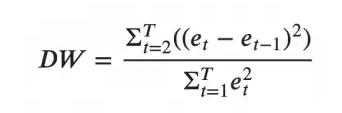

The value of this statistic can vary between 0 and 4. The closer it is to the value 2, then there is no significant serial correlation. The closer to 0, there is a positive serial correlation, and the closer it is to 4 implies negative serial correlation.

In [21]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_var_fitted.resid)


for col, val in zip(train_set_differenced.columns, out):
    print(col, ':', round(val, 2))

Open : 2.03
High : 2.01
Low : 2.01
Close : 2.0
Adj Close : 2.0
Volume : 2.01


# 7-8 How to Forecast VAR model using statsmodels

In [22]:
lag_order = model_var_fitted.k_ar

# Input data for forecasting
forecast_input = pd.concat([validation_set[-lag_order-1:], test_set]) # I add -1 cause next line we have dropna which deletes the first case
forecast_input_differenced = forecast_input.copy().diff().dropna()
forecast_input = pd.concat([validation_set[-lag_order:], test_set]) # set the corrected forecast_input df having length equal to forecasts without the extra +1 case

# Forecast
nobs = forecast_input_differenced.shape[0]
fc = model_var_fitted.forecast(y = forecast_input_differenced.values, steps = nobs)
df_forecast = pd.DataFrame(fc, index = forecast_input_differenced.index, columns = forecast_input.columns + '_1d')

# 7-9 Invert the transformation to get the real forecast

In [23]:
def invert_transformation(forecast_input, df_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = forecast_input.columns
    for col in columns:        
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = forecast_input[col] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

df_results = invert_transformation(forecast_input, df_forecast)
df_results.head(lag_order+3)

,Open_1d,High_1d,Low_1d,Close_1d,Adj Close_1d,Volume_1d,Open_forecast,High_forecast,Low_forecast,Close_forecast,Adj Close_forecast,Volume_forecast
Date,,,,,,,,,,,,
2023-09-21,0.082468,0.100454,-0.069551,-0.030744,-0.027750,-3593.035284,7.702468,7.860454,7.530449,7.669255,7.672249,2708.964716
2023-09-22,-0.083349,-0.051192,-0.023351,-0.001209,-0.003059,4804.974828,7.759119,7.949261,7.667099,7.788046,7.789191,7626.939544
2023-09-25,0.000531,0.000638,0.050511,0.049131,0.048089,-816.433925,7.899650,8.029899,7.857610,7.997178,7.997280,3445.505620
2023-09-26,0.003571,0.013635,-0.027866,-0.010097,-0.006473,240.361409,8.003221,8.063534,7.829744,7.987081,7.990807,1881.867029
2023-09-27,-0.008061,0.003452,-0.023503,-0.012982,-0.014990,-2092.777008,8.195159,8.466986,8.066241,8.154099,8.155817,60406.090021
2023-09-28,-0.040674,-0.026966,0.003576,0.006452,0.008282,-600.393895,8.134486,8.220020,8.049818,8.160551,8.164099,35894.696126
2023-09-29,0.036651,0.025678,0.017201,0.004077,0.004697,5698.852723,8.271136,8.565698,8.067018,8.324627,8.328796,18408.548849
2023-10-02,0.021664,0.005995,0.017952,0.011000,0.011054,-3827.223752,8.332800,8.511692,8.204971,8.335628,8.339849,21660.325096
2023-10-03,0.005962,0.004993,-0.006917,-0.008999,-0.006848,-889.179174,8.298762,8.516685,8.178053,8.306630,8.313002,10614.145923


# 7-10 Plots of Forecasts vs Actuals

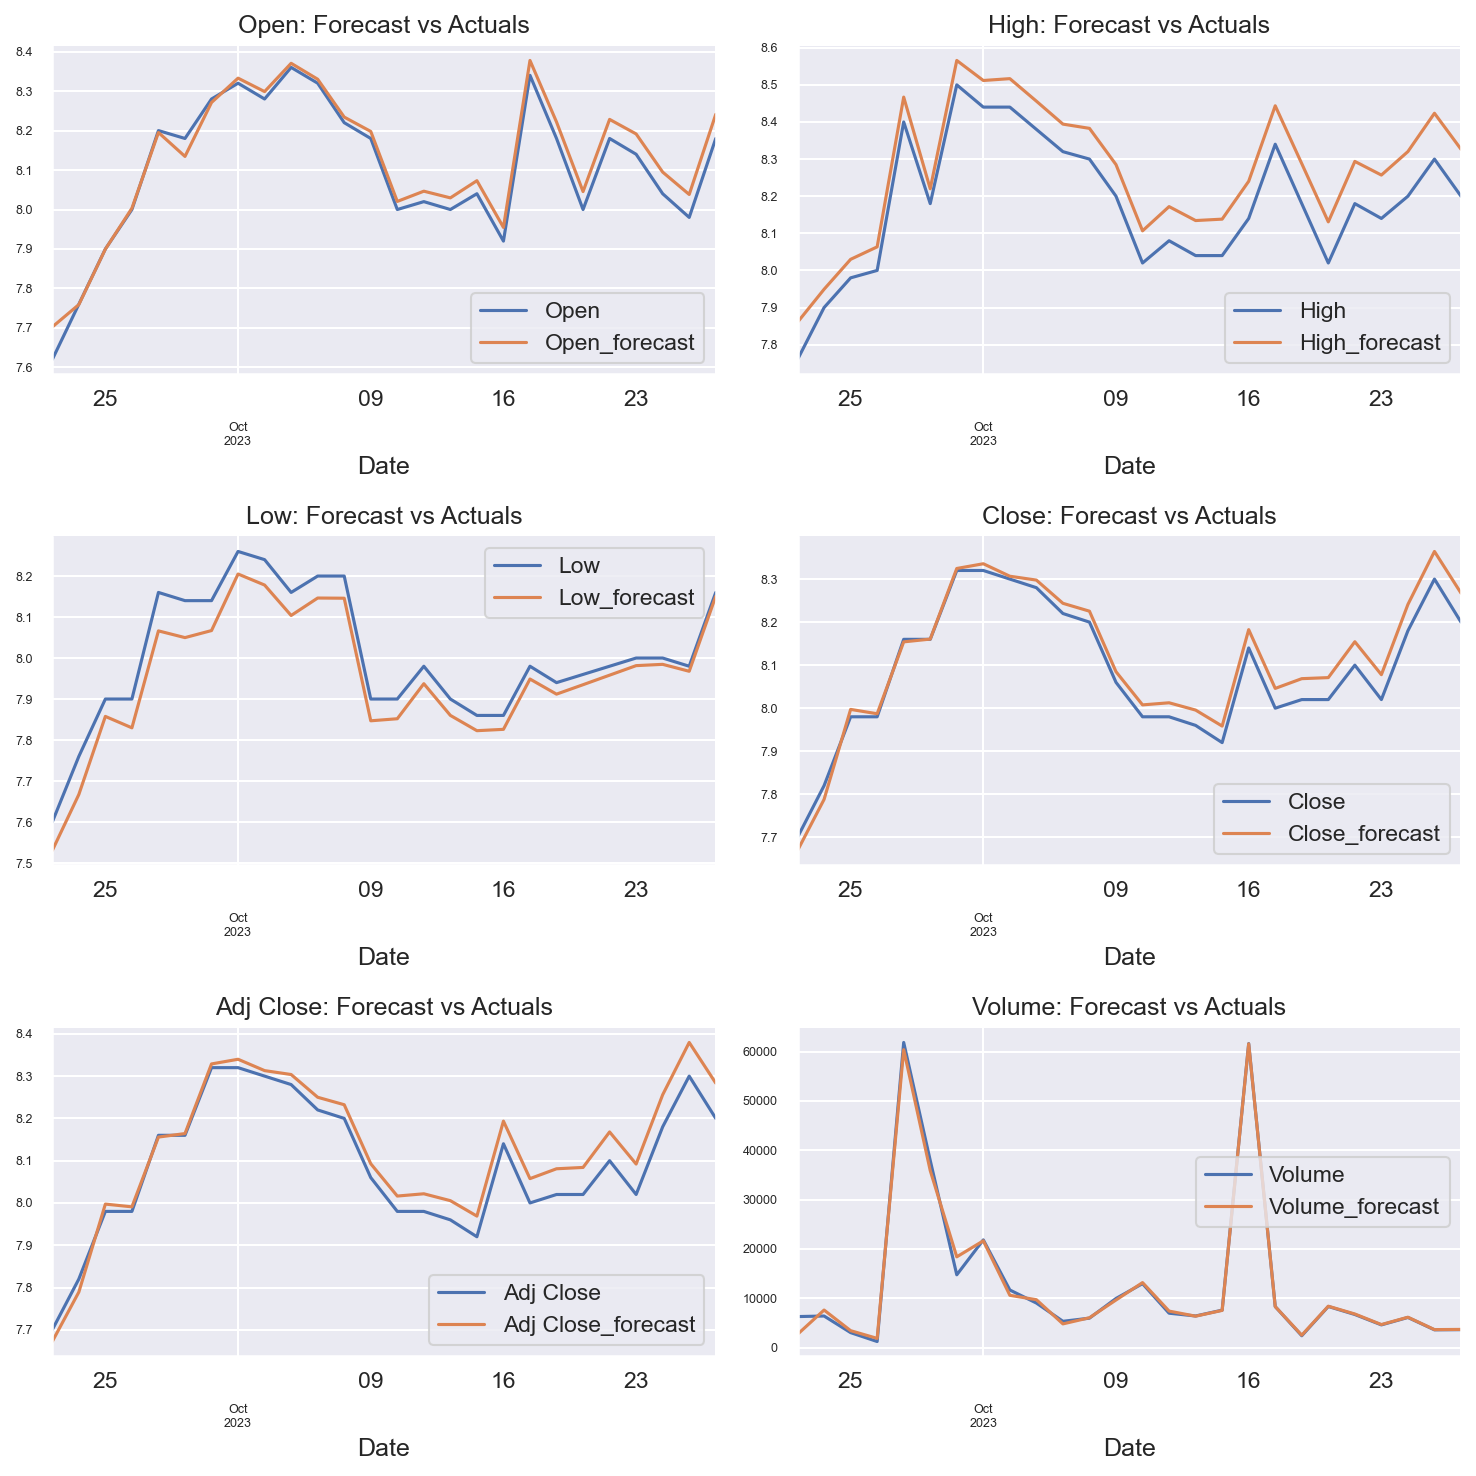

In [24]:
fig, axes = plt.subplots(nrows=int(len(forecast_input.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(forecast_input.columns, axes.flatten())):
    forecast_input[col].plot(legend=True, ax=ax)
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();


# 7-11 Calculate RMSE for VAR model

Root Mean Squared Error (RMSE): 0.042664662772328416


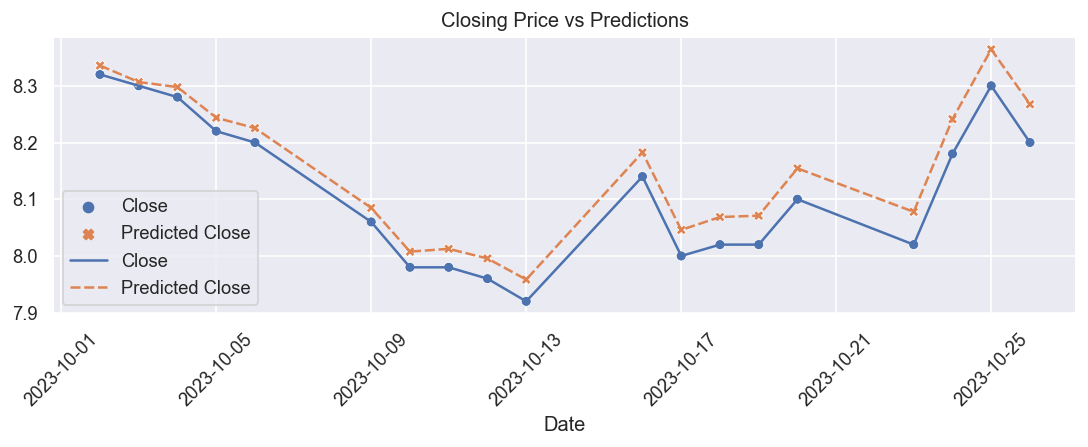

In [25]:
forecasts = df_results[df_results.index >= test_start_time]["Close_forecast"]

# evaluate forecasts against test_set
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test_set['Close'], forecasts)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")


#plot Close and predicted Close price
plot_df = pd.DataFrame({'Date': test_set.index,
                    'Close': test_set['Close'],
                    'Predicted Close': forecasts
                        })


my_plot = sns.set(rc={'figure.figsize':(11, 3)})
plt.figure()
my_plot = sns.scatterplot(plot_df)
my_plot = sns.lineplot(plot_df)
my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45)
my_plot.set(title='Closing Price vs Predictions')

df_default_model_with_lagged_features_rmse_performance.loc['VAR'] = rmse
df_tuned_model_with_lagged_features_rmse_performance.loc['VAR'] = rmse

# 8 Machine Learning models

# Prepare the closing price target variable

# PANDAS TA

In [151]:
def financial_indicators(main_df):

    import pandas_ta as ta

    # simple moving average
    sma = ta.sma(main_df["Close"], length=7)
    main_df['sma'] = sma

    # Weighted Moving Average: wma
    wma = ta.wma(main_df["Close"], length=7)
    main_df['wma'] = wma

    # Momemtum
    mom = ta.mom(main_df["Close"], length=2)
    main_df['mom'] = mom

    # stochastic ochilator
    stoch = ta.stoch(high = main_df["High"], low = main_df["Low"], close = main_df["Close"])
    main_df['stoch_k'] = stoch["STOCHk_14_3_3"]
    main_df['stoch_d'] = stoch["STOCHd_14_3_3"]

    # RSI
    rsi = ta.rsi(main_df["Close"], length=7)
    main_df['rsi'] = rsi

    # MACD
    macd = ta.macd(main_df["Close"])
    main_df['macd'] = macd['MACD_12_26_9']

    # William's R
    willr = ta.willr(high = main_df["High"], low = main_df["Low"], close = main_df["Close"], length=7)
    main_df['willr'] = willr

    # A/D (Accumulation/Distribution) Oscillator
    adosc = ta.adosc(high = main_df["High"], low = main_df["Low"], close = main_df["Close"], volume = main_df['Volume'])
    main_df['adosc'] = adosc

    # Commodity Channel Index: cci
    cci = ta.cci(high = main_df["High"], low = main_df["Low"], close = main_df["Close"])
    main_df['cci'] = cci

    main_df.dropna(inplace=True)

    return main_df

initial_df = get_stock_data("KRI.AT")
main_df = financial_indicators(initial_df.copy())
main_df.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace=True)
main_df.tail()

[*********************100%%**********************]  1 of 1 completed


,Close,sma,wma,mom,stoch_k,stoch_d,rsi,macd,willr,adosc,cci
Date,,,,,,,,,,,
2023-10-23,8.02,8.031429,8.040000,0.00,33.244992,29.795782,46.763846,-0.007157,-66.666600,13765.363275,-16.542895
2023-10-24,8.18,8.068572,8.077143,0.08,46.271796,36.946233,61.576885,0.004038,-33.333300,12941.576979,61.149398
2023-10-25,8.30,8.091429,8.135000,0.28,63.034223,47.517003,69.100089,0.022337,-9.999988,12578.293769,139.059823
2023-10-26,8.20,8.120000,8.162143,0.02,76.388879,61.898299,58.049694,0.028441,-27.777873,12655.958189,128.565760
2023-10-27,8.08,8.128572,8.152143,-0.22,69.444409,69.622504,47.430674,0.023327,-64.705932,10251.574707,51.568001


# 8-1 Split the dataset for ML

In [152]:
def split_dataset_for_ml(main_df, 
                            train_start = '2020-01-01',
                            train_end = '2022-12-31', 
                            validation_start = '2023-01-01',
                            validation_end = '2023-08-31',
                            test_start = '2023-09-01',
                            test_end = '2023-09-30'):
    
    
    # Prepare the closing price as target variable    
    main_df['target'] = main_df['Close'].shift(-1)


    # Split the data into train, validation, and test sets
    train_set = main_df[(main_df.index >= train_start) & (main_df.index <= train_end)]
    validation_set = main_df[(main_df.index >= validation_start) & (main_df.index <= validation_end)]
    train_and_validation_set = pd.concat([train_set, validation_set], axis=0)

    test_set = main_df[(main_df.index >= test_start) & (main_df.index <= test_end)]
    test_set = test_set[:-1]


    return train_set, validation_set, train_and_validation_set, test_set

# 8-2 Make the Train/Valid/Test split for ML

In [153]:
train_set, validation_set, train_and_validation_set, test_set = split_dataset_for_ml(main_df.copy(), 
                            train_start = train_start_time,
                            train_end = train_end_time, 
                            validation_start = validation_start_time,
                            validation_end = validation_end_time,
                            test_start = test_start_time,
                            test_end = test_end_time)



# Print the sizes of the sets
print("Train Set Size:", len(train_set))
print("Validation Set Size:", len(validation_set))
print("Test Set Size:", len(test_set))


Train Set Size: 1245
Validation Set Size: 497
Test Set Size: 205


# 8-3 Default Random Forest Model

RMSE: 1.2365454795280304


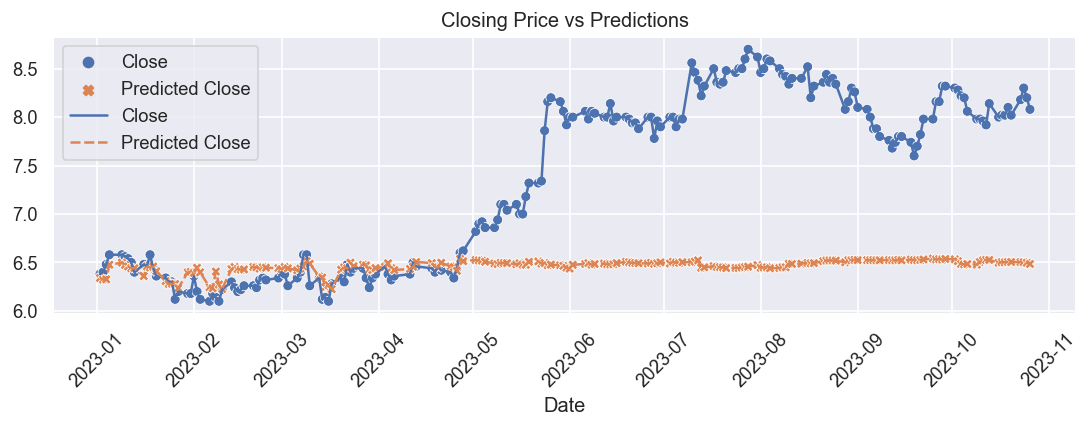

In [155]:
def build_random_forest_default_model(train_set, test_set):

    from sklearn.ensemble import RandomForestRegressor    
    
    #scaling the data before modeling
    scaler = StandardScaler()
    scaled_array = scaler.fit_transform(train_set)
    train_data = pd.DataFrame(scaled_array, columns=train_set.columns, index=train_set.index)
    
    scaled_array = scaler.transform(test_set)
    test_data = pd.DataFrame(scaled_array, columns=test_set.columns, index=test_set.index)

    
    # Prepare the data for Random Forest
    X_train = train_data.drop(['target'], axis=1, inplace=False)
    y_train = train_data['target']

    X_test = test_data.drop(['target'], axis=1, inplace=False)
    y_test = test_data['target']
    
    
    # Train the Random Forest model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=4)
    rf_model.fit(X_train, y_train)

    # Make predictions using the trained model
    y_pred = rf_model.predict(X_test)
    
    
    # unscale y_pred_diff
    train_data = train_set
    test_data = test_set
    y_pred = (y_pred * train_data['Close'].std()) + train_data['Close'].mean()
    
    test_data["y_pred"] = y_pred
    
    
    # Calculate RMSE (Root Mean Squared Error) to evaluate the model's performance
    rmse = np.sqrt(mean_squared_error(test_data["target"], test_data["y_pred"]))
    print(f"RMSE: {rmse}")


    #plot Close and predicted Close price
    plot_df = pd.DataFrame({'Date': test_data.index,
                       'Close': test_data['target'],
                       'Predicted Close': test_data['y_pred']
                           })


    my_plot = sns.set(rc={'figure.figsize':(11, 3)})
    plt.figure()
    my_plot = sns.scatterplot(plot_df)
    my_plot = sns.lineplot(plot_df)
    my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45)
    my_plot.set(title='Closing Price vs Predictions')
    
    
    return rf_model, rmse

rf_model_default, rf_model_rmse = build_random_forest_default_model(train_set.copy(), test_set.copy())

# Save the model performance
df_default_model_rmse_performance.loc['rf'] = rf_model_rmse

# 8-3-1 Find best ML lag values

In [87]:
def get_series_with_lag(main_df, model_str='RandomForest'):
    
    import pandas as pd
    import numpy as np
    
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.svm import SVR
    import xgboost as xgb
    from sklearn.neighbors import KNeighborsRegressor
    from tensorflow import keras
    
    from sklearn.metrics import mean_squared_error
    from sklearn.preprocessing import MinMaxScaler

    # Specify the maximum lag period to consider
    max_lag_period = 7

    # Create empty lists to store lag periods and corresponding RMSE scores
    lag_periods = []
    rmse_scores = []


    features = main_df.columns
    print(model_str)

    # Create lag features and evaluate RMSE for each lag period
    for lag_period in range(0, max_lag_period + 1):
         
            
        if lag_period > 0:
        # Create lag features
            for feature in features:
                main_df['{}_Lag_{}'.format(feature, lag_period)] = main_df[feature].shift(lag_period)
                
                # fill NaN values
                main_df.dropna(inplace=True)

        train_set, validation_set, train_and_validation_set, test_set = split_dataset_for_ml(main_df.copy(), 
                            train_start = train_start_time,
                            train_end = train_end_time, 
                            validation_start = validation_start_time,
                            validation_end = validation_end_time,
                            test_start = test_start_time)
                
        #scaling the data before modeling
        scaler = StandardScaler()
        scaled_array = scaler.fit_transform(train_set)
        train_data = pd.DataFrame(scaled_array, columns=train_set.columns, index=train_set.index)

        scaled_array = scaler.transform(validation_set)
        validation_data = pd.DataFrame(scaled_array, columns=validation_set.columns, index=validation_set.index)

        X_train = train_data.drop(['target'], axis=1)
        y_train = train_data['target']
        X_valid = validation_data.drop(['target'], axis=1)
        y_valid = validation_data['target']
        

        # Train a model
        
        # Set a random seed
        np.random.seed(42)
        
        if model_str=='SVM':
            model = SVR(kernel='linear')
            model.fit(X_train, y_train)
        elif model_str=="RandomForest":
            model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=4)
            model.fit(X_train, y_train)
        elif model_str=="XGBoost":
            model = xgb.XGBRegressor(n_estimators=100, random_state=42)
            model.fit(X_train, y_train)
        elif model_str=="kNN":
            model = KNeighborsRegressor(n_neighbors=3)
            model.fit(X_train, y_train)
        elif model_str=="LSTM":

            # build the LSTM model
            model = keras.models.Sequential()
            model.add(keras.layers.LSTM(units=20, activation='relu', input_shape=(X_train.shape[1], 1)))
            model.add(keras.layers.Dense(units=1))

            # Compile the model
            model.compile(optimizer='adam', loss='mean_squared_error')
    
            # Train the Model
            callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
            model.fit(X_train, y_train, epochs=500, batch_size=7, callbacks=[callback], verbose=0)
            
            
        else:
            print("Please select a model like: 'SVM', 'RandomForest', 'XGBoost', 'kNN', 'LSTM'")
            return None

        # Make predictions on the validation set
        y_pred = model.predict(X_valid)


        # unscale y_pred
        train_data = train_set
        validation_data = validation_set
        y_pred = (y_pred * train_data['target'].std()) + train_data['target'].mean()

        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(validation_data['target'], y_pred))
        print("{} rmse with lag {}".format(rmse, lag_period))

        # Store lag period and RMSE
        lag_periods.append(lag_period)
        rmse_scores.append(rmse)

    # Find the best lag period with the lowest RMSE
    best_lag_period = lag_periods[np.argmin(rmse_scores)]
    best_rmse = rmse_scores[np.argmin(rmse_scores)]

    print("Best Lag Period: {}".format(best_lag_period))
    print("Best RMSE: {}".format(best_rmse))

    return best_lag_period, best_rmse

best_lag_period_rf, best_rmse_rf = get_series_with_lag(main_df.copy(), "RandomForest")

best_lag_period_svm, best_rmse_svm = get_series_with_lag(main_df.copy(), "SVM")

best_lag_period_xgb, best_rmse_xgb = get_series_with_lag(main_df.copy(), "XGBoost")

best_lag_period_knn, best_rmse_knn = get_series_with_lag(main_df.copy(), "kNN")

""" best_lag_period_lstm, best_rmse_lstm = get_series_with_lag(main_df.copy(), "LSTM") """

RandomForest


1.1979961571346955 rmse with lag 0
1.2030317285586598 rmse with lag 1
1.1957545758610486 rmse with lag 2
1.1981364045954495 rmse with lag 3
1.1873781268150372 rmse with lag 4
1.1864815349383504 rmse with lag 5
1.1839999729229034 rmse with lag 6
1.184950435823597 rmse with lag 7
Best Lag Period: 6
Best RMSE: 1.1839999729229034
SVM
0.12627272665970152 rmse with lag 0
0.13138831833534323 rmse with lag 1
0.1318200664126722 rmse with lag 2
0.13560709455427977 rmse with lag 3
0.13574275308723543 rmse with lag 4
0.13639018496508293 rmse with lag 5
0.13892521849303296 rmse with lag 6
0.1395857013983068 rmse with lag 7
Best Lag Period: 0
Best RMSE: 0.12627272665970152
XGBoost
1.2323126823497426 rmse with lag 0
1.2256274664881301 rmse with lag 1
1.209417042874899 rmse with lag 2
1.2267716227999605 rmse with lag 3
1.21779262418414 rmse with lag 4
1.2049866993320544 rmse with lag 5
1.2230633691765267 rmse with lag 6
1.2469758952731205 rmse with lag 7
Best Lag Period: 5
Best RMSE: 1.204986699332054

' best_lag_period_lstm, best_rmse_lstm = get_series_with_lag(main_df.copy(), "LSTM") '

# 8-3-2 Get Train/Valid/Test set after finding best lag / order

In [65]:
def get_datasets_after_finding_best_lags(main_df, best_lag_period):

    columns = main_df.columns

    for lag_period in range(1, best_lag_period+1):
    # Create lag features
        for feature in columns:
            main_df['{}_Lag_{}'.format(feature, lag_period)] = main_df[feature].shift(lag_period)

            # fill NaN values
            main_df.dropna(inplace=True)

    lagged_train_set, lagged_validation_set, lagged_train_and_validation_set, lagged_test_set = split_dataset_for_ml(main_df.copy(), 
                        train_start = train_start_time,
                        train_end = train_end_time, 
                        validation_start = validation_start_time,
                        validation_end = validation_end_time,
                        test_start = test_start_time,
                        test_end = test_end_time)
    
    

    return lagged_train_set, lagged_validation_set, lagged_test_set

# 8-3-4 Build Default RandomForest after finding the optimal lag / order

RMSE: 1.2126154237824898


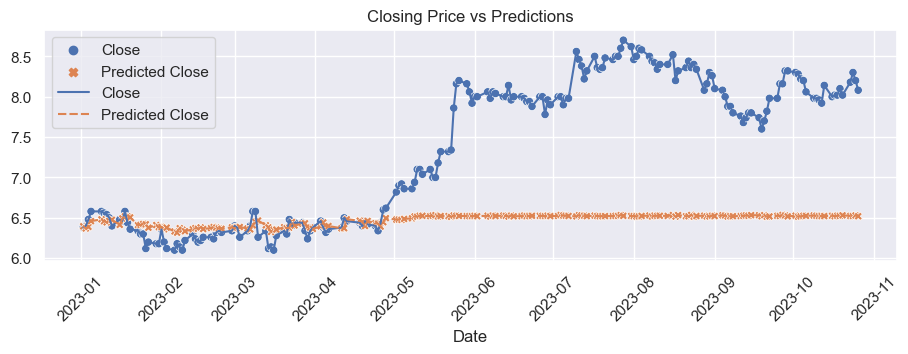

In [66]:
# # build train/valid/test optimal lagged datasets for RF
lagged_train_set, lagged_validation_set, lagged_test_set = get_datasets_after_finding_best_lags(main_df.copy(), best_lag_period_rf)

# build RF model with lagged values and default parameters
rf_model_default_lagged, rf_model_default_lagged_rmse = build_random_forest_default_model(lagged_train_set.copy(), lagged_test_set.copy())

# Save the model's performance
df_default_model_with_lagged_features_rmse_performance.loc['rf'] = rf_model_default_lagged_rmse

# 8-3-5 Tuned Random Forest

100%|██████████| 150/150 [03:09<00:00,  1.26s/trial, best loss: 0.10274798995356658]
{'criterion': 'squared_error', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 9, 'n_estimators': 150}
0.10148695886004439 rmse


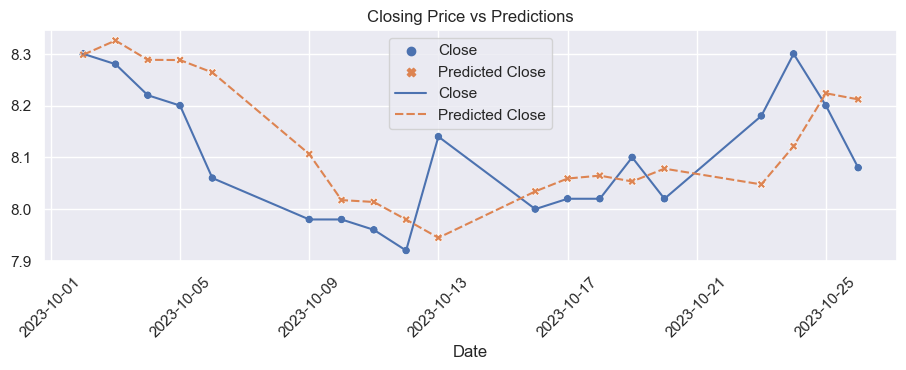

In [35]:
def randomforest_tuning(train_set, validation_set, test_set):

    from hyperopt import hp, tpe, fmin, Trials, space_eval
    from sklearn.ensemble import RandomForestRegressor
    from hyperopt.pyll import scope

    # Set a random seed
    ''' 
    By setting the random seed with np.random.seed(42), 
    you ensure that the random sampling in Hyperopt is reproducible across runs 
    as long as the seed remains the same.
    '''
    np.random.seed(42)

    # Define the search space for hyperparameters
    space = {
        "criterion": hp.choice("criterion", ['squared_error', 'friedman_mse', 'absolute_error']),
        "n_estimators": scope.int(hp.quniform("n_estimators", 100, 200, 10)),
        "max_depth": scope.int(hp.quniform("max_depth", 2, 12, 1)),
        'min_samples_split': scope.int(hp.quniform("min_samples_split", 2, 10, 1)),
        'min_samples_leaf': scope.int(hp.quniform("min_samples_leaf", 1, 10, 1)),
        "max_features": hp.choice("max_features", ['sqrt', 'log2'])
    }

    # Define the objective function to minimize (negative mean squared error)
    def objective(params):

        #scaling the data before modeling
        scaler = StandardScaler()
        scaled_array = scaler.fit_transform(train_set)
        train_data = pd.DataFrame(scaled_array, columns=train_set.columns, index=train_set.index)
        
        scaled_array = scaler.transform(validation_set)
        validation_data = pd.DataFrame(scaled_array, columns=validation_set.columns, index=validation_set.index)

        
        # Prepare the data for Random Forest
        X_train = train_data.drop(['target'], axis=1, inplace=False)
        y_train = train_data['target']

        X_test = validation_data.drop(['target'], axis=1, inplace=False)
        y_test = validation_data['target']

        model = RandomForestRegressor(
            criterion = params['criterion'],
            n_estimators=params['n_estimators'],
            max_depth=params['max_depth'],
            min_samples_split=params['min_samples_split'],
            min_samples_leaf=params['min_samples_leaf'],
            max_features=params['max_features'],
            random_state=42,
            n_jobs=4
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # unscale y_pred_diff
        train_data = train_set
        validation_data = validation_set
        y_pred = (y_pred * train_data['Close'].std()) + train_data['Close'].mean()
        y_test = validation_data['target']

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        return rmse

    # Create an instance of the Trials class to keep track of the results
    trials = Trials()

    # Run the hyperparameter search using the TPE algorithm
    best = fmin(fn=objective,
                space=space,
                algo=tpe.suggest,
                max_evals=150,
                trials=trials,
                rstate=np.random.default_rng(42))

    # Get the best hyperparameters
    best_params = space_eval(space, best)
    print(best_params)

    # Train the final model with the best hyperparameters

    #scaling the data before modeling
    scaler = StandardScaler()
    scaled_array = scaler.fit_transform(train_set)
    train_data = pd.DataFrame(scaled_array, columns=train_set.columns, index=train_set.index)

    scaled_array = scaler.transform(test_set)
    test_data = pd.DataFrame(scaled_array, columns=test_set.columns, index=test_set.index)


    # Prepare the data for Random Forest
    X_train = train_data.drop(['target'], axis=1, inplace=False)
    y_train = train_data['target']

    X_test = test_data.drop(['target'], axis=1, inplace=False)
    y_test = test_data['target']


    final_model = RandomForestRegressor(**best_params, random_state=42)
    final_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = final_model.predict(X_test)

    # unscale y_pred_diff
    train_data = train_set
    test_data = test_set
    y_pred = (y_pred * train_data['Close'].std()) + train_data['Close'].mean()
    y_test = test_data['target']

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print("{} rmse".format(rmse))


    #plot Close and predicted Close price
    plot_df = pd.DataFrame({'Date': test_data.index,
                       'Close': test_data['target'],
                       'Predicted Close': y_pred
                           })


    my_plot = sns.set(rc={'figure.figsize':(11, 3)})
    plt.figure()
    my_plot = sns.scatterplot(plot_df)
    my_plot = sns.lineplot(plot_df)
    my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45)
    my_plot.set(title='Closing Price vs Predictions')

    
    return final_model, rmse

rf_model_tuned_lagged, rf_model_tuned_lagged_rmse = randomforest_tuning(lagged_train_set.copy(), 
                                                    lagged_validation_set.copy(), 
                                                    lagged_test_set.copy())


# Save the model performance and model name
df_tuned_model_with_lagged_features_rmse_performance.loc["rf_tuned"] = rf_model_tuned_lagged_rmse

# 8-4 Default XGBoost

RMSE: 1.284960109490151


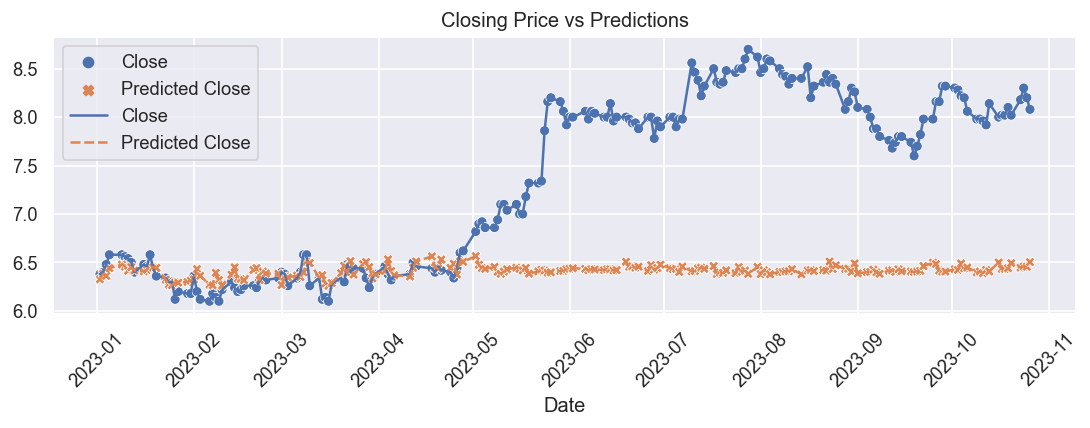

In [159]:
def build_xgboost_default_model(train_set, test_set):
    
    import xgboost as xgb
    
    #scaling the data before modeling
    scaler = StandardScaler()
    scaled_array = scaler.fit_transform(train_set)
    train_data = pd.DataFrame(scaled_array, columns=train_set.columns, index=train_set.index)
    
    scaled_array = scaler.transform(test_set)
    test_data = pd.DataFrame(scaled_array, columns=test_set.columns, index=test_set.index)

    
    # Prepare the data for Random Forest
    X_train = train_data.drop(['target'], axis=1, inplace=False)
    y_train = train_data['target']

    X_test = test_data.drop(['target'], axis=1, inplace=False)
    y_test = test_data['target']
    
    
    # Train the Random Forest model
    xgb_model = xgb.XGBRegressor(n_estimators=100, seed=42)
    xgb_model.fit(X_train, y_train)

    # Make predictions using the trained model
    y_pred = xgb_model.predict(X_test)
    
    test_set["y_pred"] = y_pred
    
    
    # unscale y_pred_diff
    train_data = train_set
    test_data = test_set
    y_pred = (y_pred * train_data['Close'].std()) + train_data['Close'].mean()
    
    test_data["y_pred"] = y_pred
    
    
    # Calculate RMSE (Root Mean Squared Error) to evaluate the model's performance
    rmse = np.sqrt(mean_squared_error(test_data["target"], test_data["y_pred"]))
    print(f"RMSE: {rmse}")


    #plot Close and predicted Close price
    
    plot_df = pd.DataFrame({'Date': test_set.index,
                       'Close': test_set['target'],
                       'Predicted Close': test_set['y_pred']
                           })


    my_plot = sns.set(rc={'figure.figsize':(11, 3)})
    plt.figure()
    my_plot = sns.scatterplot(plot_df)
    my_plot = sns.lineplot(plot_df)
    my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45)
    my_plot.set(title='Closing Price vs Predictions')
    
    return xgb_model, rmse

xgb_model_default, xgb_model_default_rmse = build_xgboost_default_model(train_set.copy(), test_set.copy())

# Save the model performance
df_default_model_rmse_performance.loc['XGBoost'] = xgb_model_default_rmse

# 8-4-1 Build Default XGBoost after finding the optimal lag / order

RMSE: 0.16868717589353263


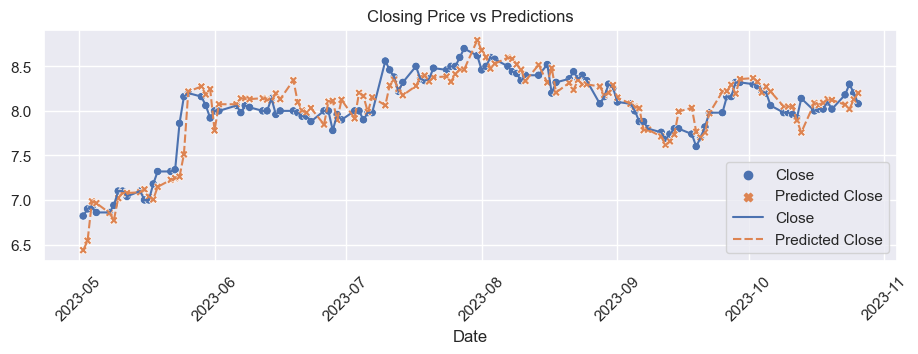

In [57]:
# build train/valid/test optimal lagged datasets for XGB
lagged_train_set, lagged_validation_set, lagged_test_set = get_datasets_after_finding_best_lags(main_df.copy(), 
                                                                                                best_lag_period_xgb)

# build XGB model with lagged values and default parameters
xgb_model_default_lagged, xgb_model_default_lagged_rmse = build_xgboost_default_model(lagged_train_set.copy(), lagged_test_set.copy())


# Save the model performance
df_default_model_with_lagged_features_rmse_performance.loc['XGBoost'] = xgb_model_default_lagged_rmse

# 8-4-2 Tuned XGBoost

100%|██████████| 150/150 [01:25<00:00,  1.75trial/s, best loss: 0.09082035251842865]
{'gamma': 0.6000000000000001, 'learning_rate': 0.225, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 160, 'subsample': 0.9}
0.09644181320993113 rmse


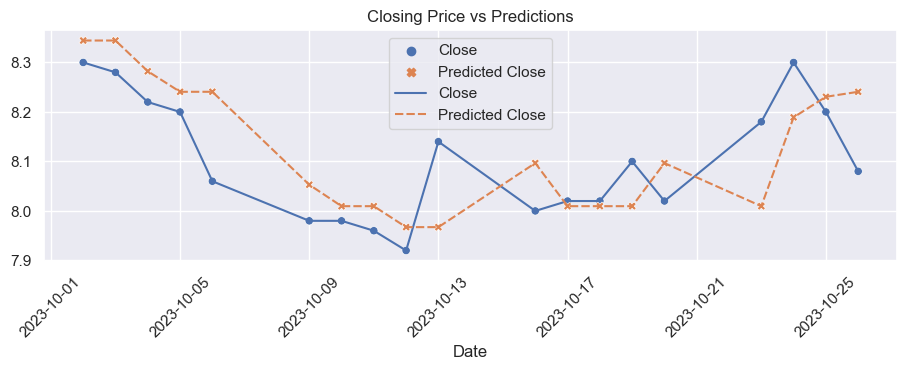

In [90]:
def xgboost_tuning(train_set, validation_set, test_set):

    from hyperopt import hp, tpe, fmin, Trials, space_eval
    import xgboost as xgb

    # Set a random seed
    ''' 
    By setting the random seed with np.random.seed(42), 
    you ensure that the random sampling in Hyperopt is reproducible across runs 
    as long as the seed remains the same.
    '''
    np.random.seed(42)

    # Define the search space for hyperparameters
    space = {
        'n_estimators': hp.choice('n_estimators', range(100, 210, 10)),
        'max_depth': hp.choice('max_depth', range(1, 15)),
        'learning_rate':  hp.quniform('learning_rate', 0.025, 0.5, 0.025),
        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
        'min_child_weight': hp.choice('min_child_weight', range(1, 11)),
        'gamma': hp.quniform('gamma', 0.4, 1, 0.05),
    }

    # Define the objective function to minimize (negative mean squared error)
    def objective(params):

        #scaling the data before modeling
        scaler = StandardScaler()
        scaled_array = scaler.fit_transform(train_set)
        train_data = pd.DataFrame(scaled_array, columns=train_set.columns, index=train_set.index)
        
        scaled_array = scaler.transform(validation_set)
        validation_data = pd.DataFrame(scaled_array, columns=validation_set.columns, index=validation_set.index)

        
        # Prepare the data for Random Forest
        X_train = train_data.drop(['target'], axis=1, inplace=False)
        y_train = train_data['target']

        X_test = validation_data.drop(['target'], axis=1, inplace=False)
        y_test = validation_data['target']

        model = xgb.XGBRegressor(
            n_estimators=params['n_estimators'],
            max_depth=params['max_depth'],
            learning_rate=params['learning_rate'],
            subsample=params['subsample'],
            min_child_weight=params['min_child_weight'],
            gamma=params['gamma'],
            objective='reg:squarederror'
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # unscale y_pred_diff
        train_data = train_set
        validation_data = validation_set
        y_pred = (y_pred * train_data['Close'].std()) + train_data['Close'].mean()
        y_test = validation_data['target']

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        return rmse

    # Create an instance of the Trials class to keep track of the results
    trials = Trials()

    # Run the hyperparameter search using the TPE algorithm
    best = fmin(fn=objective,
                space=space,
                algo=tpe.suggest,
                max_evals=150,
                trials=trials,
                rstate=np.random.default_rng(42))

    # Get the best hyperparameters
    best_params = space_eval(space, best)
    print(best_params)

    # Train the final model with the best hyperparameters

    #scaling the data before modeling
    scaler = StandardScaler()
    scaled_array = scaler.fit_transform(train_set)
    train_data = pd.DataFrame(scaled_array, columns=train_set.columns, index=train_set.index)

    scaled_array = scaler.transform(test_set)
    test_data = pd.DataFrame(scaled_array, columns=test_set.columns, index=test_set.index)


    # Prepare the data for Random Forest
    X_train = train_data.drop(['target'], axis=1, inplace=False)
    y_train = train_data['target']

    X_test = test_data.drop(['target'], axis=1, inplace=False)
    y_test = test_data['target']


    final_model = xgb.XGBRegressor(**best_params, random_state=42)
    final_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = final_model.predict(X_test)

    # unscale y_pred_diff
    train_data = train_set
    test_data = test_set
    y_pred = (y_pred * train_data['Close'].std()) + train_data['Close'].mean()
    y_test = test_data['target']

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print("{} rmse".format(rmse))


    #plot Close and predicted Close price
    plot_df = pd.DataFrame({'Date': test_data.index,
                       'Close': test_data['target'],
                       'Predicted Close': y_pred
                           })


    my_plot = sns.set(rc={'figure.figsize':(11, 3)})
    plt.figure()
    my_plot = sns.scatterplot(plot_df)
    my_plot = sns.lineplot(plot_df)
    my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45)
    my_plot.set(title='Closing Price vs Predictions')


    return final_model, rmse

xgboost_model_tuned_lagged, xgboost_model_tuned_lagged_rmse = xgboost_tuning(lagged_train_set.copy(), 
                                                     lagged_validation_set.copy(), 
                                                     lagged_test_set.copy())


# Save the model performance and model name
df_tuned_model_with_lagged_features_rmse_performance.loc["XGBoost_tuned"] = xgboost_model_tuned_lagged_rmse

# 8-5 Default SVM

RMSE: 0.11154118729938517


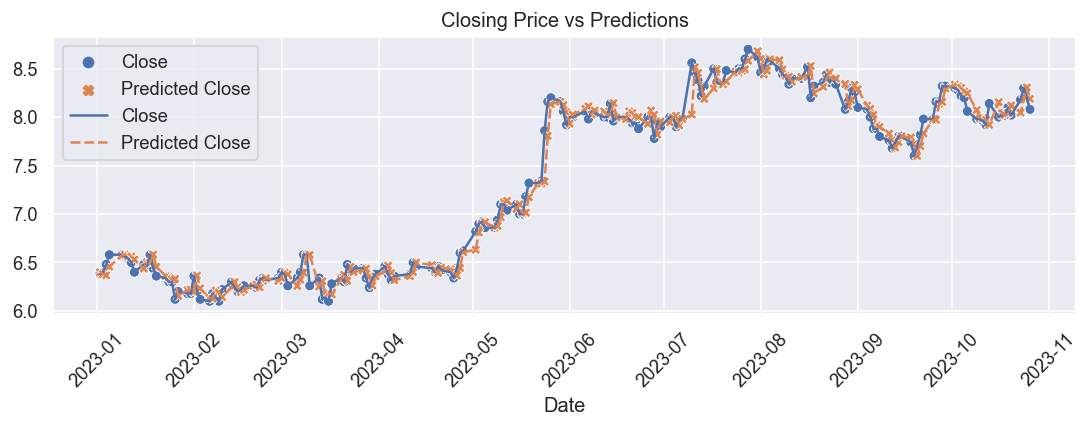

In [158]:
def build_svm_default_model(train_set, test_set):
    
    from sklearn.svm import SVR

    #scaling the data before modeling
    scaler = StandardScaler()
    scaled_array = scaler.fit_transform(train_set)
    train_data = pd.DataFrame(scaled_array, columns=train_set.columns, index=train_set.index)
    
    scaled_array = scaler.transform(test_set)
    test_data = pd.DataFrame(scaled_array, columns=test_set.columns, index=test_set.index)

    
    # Prepare the data for Random Forest
    X_train = train_data.drop(['target'], axis=1, inplace=False)
    y_train = train_data['target']

    X_test = test_data.drop(['target'], axis=1, inplace=False)
    y_test = test_data['target']
    
    
    # Train the Random Forest model
    svm = SVR(kernel='linear')
    svm.fit(X_train, y_train)

    # Make predictions using the trained model
    y_pred = svm.predict(X_test)
    
    # unscale y_pred_diff
    train_data = train_set
    test_data = test_set
    y_pred = (y_pred * train_data['Close'].std()) + train_data['Close'].mean()
    
    test_data["y_pred"] = y_pred
    
    
    # Calculate RMSE (Root Mean Squared Error) to evaluate the model's performance
    rmse = np.sqrt(mean_squared_error(test_data["target"], test_data["y_pred"]))
    print(f"RMSE: {rmse}")


    #plot Close and predicted Close price
    
    plot_df = pd.DataFrame({'Date': test_set.index,
                       'Close': test_set['target'],
                       'Predicted Close': test_set['y_pred']
                           })


    my_plot = sns.set(rc={'figure.figsize':(11, 3)})
    plt.figure()
    my_plot = sns.scatterplot(plot_df)
    my_plot = sns.lineplot(plot_df)
    my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45)
    my_plot.set(title='Closing Price vs Predictions')
    
   
    return svm, rmse

svm_model_default, svm_model_default_rmse = build_svm_default_model(train_set.copy(), test_set.copy())

# Save the model performance
df_default_model_rmse_performance.loc['svm'] = svm_model_default_rmse

# 8-5-1 Build Default SVM after finding the optimal lag / order

RMSE: 0.09367265413502981


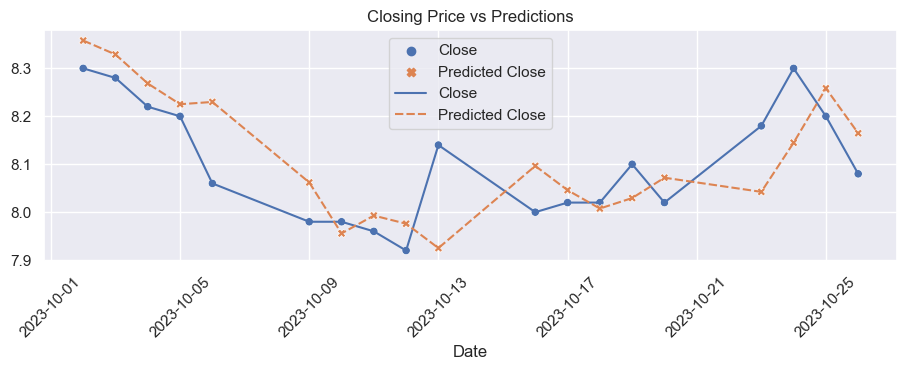

In [85]:
# build train/valid/test optimal lagged datasets for SVM
lagged_train_set, lagged_validation_set, lagged_test_set = get_datasets_after_finding_best_lags(main_df.copy(), 
                                                                                                best_lag_period_svm)

# build SVM model with lagged values and default parameters
svm_model_default_lagged, svm_model_default_lagged_rmse = build_svm_default_model(lagged_train_set.copy(), lagged_test_set.copy())

# Save the model performance
df_default_model_with_lagged_features_rmse_performance.loc['svm'] = svm_model_default_lagged_rmse

# 8-5-1 Tuned SVM

  2%|▏         | 2/100 [00:00<00:09, 10.21trial/s, best loss: 0.15647206488886803]

100%|██████████| 100/100 [00:11<00:00,  8.49trial/s, best loss: 0.09142593091331883]
{'C': 0.7323974548121089, 'degree': 1, 'epsilon': 0.11592868688119527, 'kernel': 'linear'}
0.09108848214340437 rmse


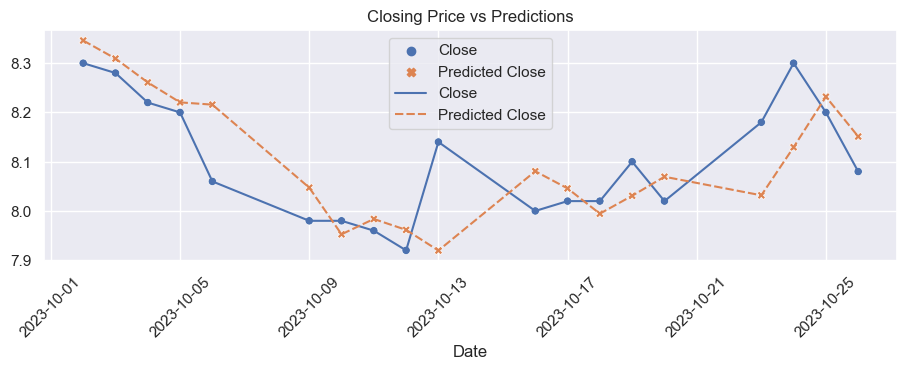

In [91]:
def svr_tuning(train_set, validation_set, test_set):

    from hyperopt import hp, tpe, fmin, Trials, space_eval
    from sklearn.svm import SVR

    # Set a random seed
    ''' 
    By setting the random seed with np.random.seed(42), 
    you ensure that the random sampling in Hyperopt is reproducible across runs 
    as long as the seed remains the same.
    '''
    np.random.seed(42)

    # Define the search space for hyperparameters
    space = {
        'kernel': hp.choice('kernel', ['linear', 'rbf', 'sigmoid']),
        'degree':  hp.choice('degree', range(1, 6)),
        'C': hp.uniform('C', 0, 1),  # C parameter (log-uniform search space)
        'epsilon': hp.loguniform('epsilon', -4, 1),  # Epsilon (log-uniform search space)

    }

    # Define the objective function to minimize (negative mean squared error)
    def objective(params):

        #scaling the data before modeling
        scaler = StandardScaler()
        scaled_array = scaler.fit_transform(train_set)
        train_data = pd.DataFrame(scaled_array, columns=train_set.columns, index=train_set.index)
        
        scaled_array = scaler.transform(validation_set)
        validation_data = pd.DataFrame(scaled_array, columns=validation_set.columns, index=validation_set.index)

        
        # Prepare the data for Random Forest
        X_train = train_data.drop(['target'], axis=1, inplace=False)
        y_train = train_data['target']

        X_test = validation_data.drop(['target'], axis=1, inplace=False)
        y_test = validation_data['target']

        model = SVR(**params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # unscale y_pred_diff
        train_data = train_set
        validation_data = validation_set
        y_pred = (y_pred * train_data['Close'].std()) + train_data['Close'].mean()
        y_test = validation_data['target']

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        return rmse

    # Create an instance of the Trials class to keep track of the results
    trials = Trials()

    # Run the hyperparameter search using the TPE algorithm
    best = fmin(fn=objective,
                space=space,
                algo=tpe.suggest,
                max_evals=100,
                trials=trials,
                rstate=np.random.default_rng(42))


    # Get the best hyperparameters
    best_params = space_eval(space, best)
    print(best_params)

    # Train the final model with the best hyperparameters

    #scaling the data before modeling
    scaler = StandardScaler()
    scaled_array = scaler.fit_transform(train_set)
    train_data = pd.DataFrame(scaled_array, columns=train_set.columns, index=train_set.index)

    scaled_array = scaler.transform(test_set)
    test_data = pd.DataFrame(scaled_array, columns=test_set.columns, index=test_set.index)


    # Prepare the data for Random Forest
    X_train = train_data.drop(['target'], axis=1, inplace=False)
    y_train = train_data['target']

    X_test = test_data.drop(['target'], axis=1, inplace=False)
    y_test = test_data['target']


    final_model = SVR(**best_params)
    final_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = final_model.predict(X_test)

    # unscale y_pred_diff
    train_data = train_set
    test_data = test_set
    y_pred = (y_pred * train_data['Close'].std()) + train_data['Close'].mean()
    y_test = test_data['target']

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print("{} rmse".format(rmse))

    #plot Close and predicted Close price
    plot_df = pd.DataFrame({'Date': test_data.index,
                       'Close': test_data['target'],
                       'Predicted Close': y_pred
                           })


    my_plot = sns.set(rc={'figure.figsize':(11, 3)})
    plt.figure()
    my_plot = sns.scatterplot(plot_df)
    my_plot = sns.lineplot(plot_df)
    my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45)
    my_plot.set(title='Closing Price vs Predictions')


    return final_model, rmse

svm_model_tuned_lagged, svm_model_tuned_lagged_rmse = svr_tuning(lagged_train_set.copy(), 
                                             lagged_validation_set.copy(), 
                                             lagged_test_set.copy())


# Save the model performance
df_tuned_model_with_lagged_features_rmse_performance.loc["svm_tuned"] = svm_model_tuned_lagged_rmse

# 8-6 Default kNN

RMSE: 1.511962770560577


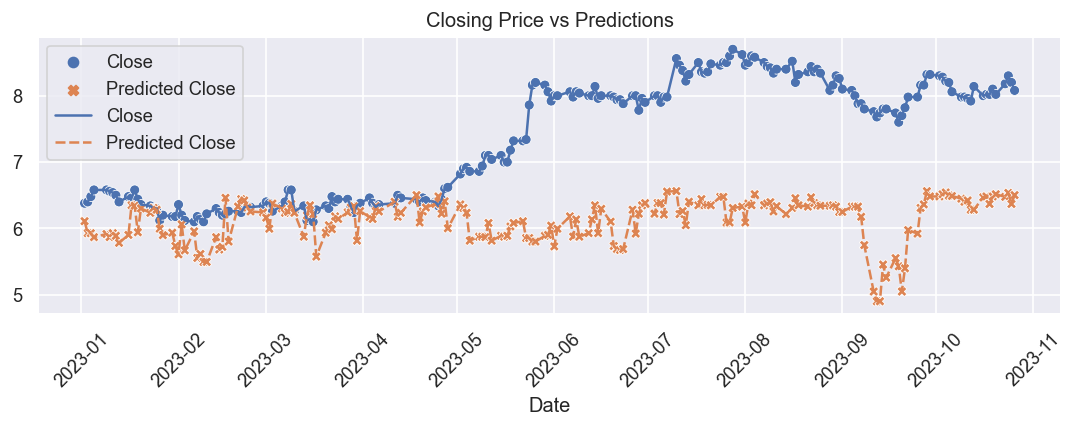

In [157]:
def build_knn_default_model(train_set, test_set):
    
    from sklearn.neighbors import KNeighborsRegressor

    #scaling the data before modeling
    scaler = StandardScaler()
    scaled_array = scaler.fit_transform(train_set)
    train_data = pd.DataFrame(scaled_array, columns=train_set.columns, index=train_set.index)
    
    scaled_array = scaler.transform(test_set)
    test_data = pd.DataFrame(scaled_array, columns=test_set.columns, index=test_set.index)

    
    # Prepare the data for Random Forest
    X_train = train_data.drop(['target'], axis=1, inplace=False)
    y_train = train_data['target']

    X_test = test_data.drop(['target'], axis=1, inplace=False)
    y_test = test_data['target']
    
    
    # Train the Random Forest model
    knn = KNeighborsRegressor(n_neighbors=3)
    knn.fit(X_train, y_train)

    # Make predictions using the trained model
    y_pred = knn.predict(X_test)
    
    # unscale y_pred_diff
    train_data = train_set
    test_data = test_set
    y_pred = (y_pred * train_data['Close'].std()) + train_data['Close'].mean()
    
    test_data["y_pred"] = y_pred
    
    
    # Calculate RMSE (Root Mean Squared Error) to evaluate the model's performance
    rmse = np.sqrt(mean_squared_error(test_data["target"], test_data["y_pred"]))
    print(f"RMSE: {rmse}")


    #plot Close and predicted Close price
    
    plot_df = pd.DataFrame({'Date': test_set.index,
                       'Close': test_set['target'],
                       'Predicted Close': test_set['y_pred']
                           })


    my_plot = sns.set(rc={'figure.figsize':(11, 3)})
    plt.figure()
    my_plot = sns.scatterplot(plot_df)
    my_plot = sns.lineplot(plot_df)
    my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45)
    my_plot.set(title='Closing Price vs Predictions')
    
    return knn, rmse

knn_model_default, knn_model_default_rmse = build_knn_default_model(train_set.copy(), test_set.copy())

# Save the model performance
df_default_model_rmse_performance.loc['kNN'] = knn_model_default_rmse

# 8-6-1 Build Default kNN after finding the optimal lag / order

RMSE: 0.1522068069722054


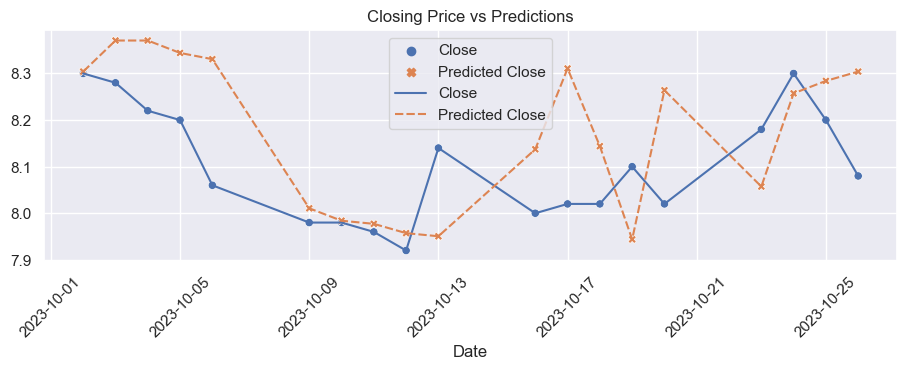

In [99]:
# build train/valid/test optimal lagged datasets for kNN
lagged_train_set, lagged_validation_set, lagged_test_set = get_datasets_after_finding_best_lags(main_df.copy(), 
                                                                                                best_lag_period_knn)

# build kNN model with lagged values and default parameters
knn_model_default_lagged, knn_model_default_lagged_rmse = build_knn_default_model(lagged_train_set.copy(), lagged_test_set.copy())


# Save the model performance
df_default_model_with_lagged_features_rmse_performance.loc['kNN'] = knn_model_default_lagged_rmse

# 8-6-1 Tuned kNN

  6%|▌         | 6/100 [00:00<00:03, 27.30trial/s, best loss: 0.16618381819408107]

100%|██████████| 100/100 [00:04<00:00, 20.42trial/s, best loss: 0.16260658594308924]
{'n_neighbors': 7, 'p': 1.0, 'weights': 'uniform'}
0.16600252510541136 rmse


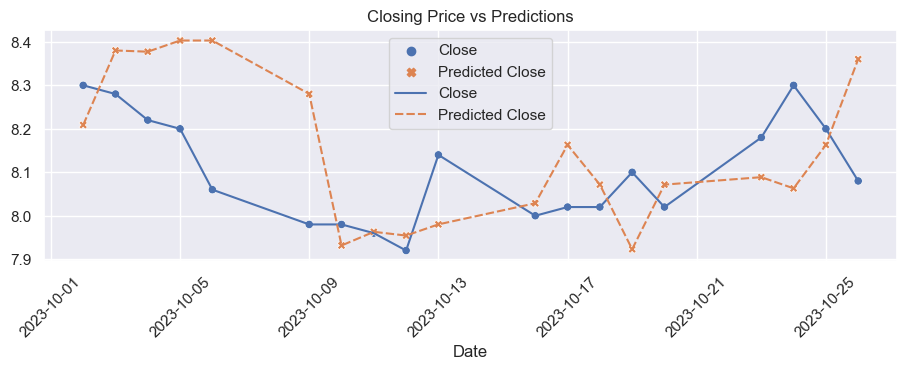

In [93]:
def kNN_tuning(train_set, validation_set, test_set):

    from hyperopt import hp, tpe, fmin, Trials, space_eval
    from sklearn.neighbors import KNeighborsRegressor

    # Set a random seed
    ''' 
    By setting the random seed with np.random.seed(42), 
    you ensure that the random sampling in Hyperopt is reproducible across runs 
    as long as the seed remains the same.
    '''
    np.random.seed(42)

    # Define the search space for hyperparameters
    space = {
        'n_neighbors': hp.choice('n_neighbors', range(1, 21)),  # Number of neighbors (integer values)
        'weights': hp.choice('weights', ['uniform', 'distance']),
        'p': hp.quniform('p', 1, 2, 1),  # Minkowski power parameter (integer values)
    }

    # Define the objective function to minimize (negative mean squared error)
    def objective(params):

        #scaling the data before modeling
        scaler = StandardScaler()
        scaled_array = scaler.fit_transform(train_set)
        train_data = pd.DataFrame(scaled_array, columns=train_set.columns, index=train_set.index)
        
        scaled_array = scaler.transform(validation_set)
        validation_data = pd.DataFrame(scaled_array, columns=validation_set.columns, index=validation_set.index)

        
        # Prepare the data for Random Forest
        X_train = train_data.drop(['target'], axis=1, inplace=False)
        y_train = train_data['target']

        X_test = validation_data.drop(['target'], axis=1, inplace=False)
        y_test = validation_data['target']

        model = KNeighborsRegressor(**params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # unscale y_pred_diff
        train_data = train_set
        validation_data = validation_set
        y_pred = (y_pred * train_data['Close'].std()) + train_data['Close'].mean()
        y_test = validation_data['target']

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        return rmse

    # Create an instance of the Trials class to keep track of the results
    trials = Trials()

    # Run the hyperparameter search using the TPE algorithm
    best = fmin(fn=objective,
                space=space,
                algo=tpe.suggest,
                max_evals=100,
                trials=trials,
                rstate=np.random.default_rng(42))


    # Get the best hyperparameters
    best_params = space_eval(space, best)
    print(best_params)

    # Train the final model with the best hyperparameters

    #scaling the data before modeling
    scaler = StandardScaler()
    scaled_array = scaler.fit_transform(train_set)
    train_data = pd.DataFrame(scaled_array, columns=train_set.columns, index=train_set.index)

    scaled_array = scaler.transform(test_set)
    test_data = pd.DataFrame(scaled_array, columns=test_set.columns, index=test_set.index)


    # Prepare the data for Random Forest
    X_train = train_data.drop(['target'], axis=1, inplace=False)
    y_train = train_data['target']

    X_test = test_data.drop(['target'], axis=1, inplace=False)
    y_test = test_data['target']


    final_model = KNeighborsRegressor(**best_params)
    final_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = final_model.predict(X_test)

    # unscale y_pred_diff
    train_data = train_set
    test_data = test_set
    y_pred = (y_pred * train_data['Close'].std()) + train_data['Close'].mean()
    y_test = test_data['target']

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print("{} rmse".format(rmse))


    #plot Close and predicted Close price
    plot_df = pd.DataFrame({'Date': test_data.index,
                       'Close': test_data['target'],
                       'Predicted Close': y_pred
                           })


    my_plot = sns.set(rc={'figure.figsize':(11, 3)})
    plt.figure()
    my_plot = sns.scatterplot(plot_df)
    my_plot = sns.lineplot(plot_df)
    my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45)
    my_plot.set(title='Closing Price vs Predictions')

    return final_model, rmse

knn_model_tuned_lagged, knn_model_tuned_lagged_rmse = kNN_tuning(lagged_train_set.copy(), 
                                             lagged_validation_set.copy(), 
                                             lagged_test_set.copy())


# Save the model performance
df_tuned_model_with_lagged_features_rmse_performance.loc["kNN_tuned"] = knn_model_tuned_lagged_rmse

# 8-7 Default LSTM

7/7 [==============================] - 2s 4ms/step
RMSE: 0.35599529629852256


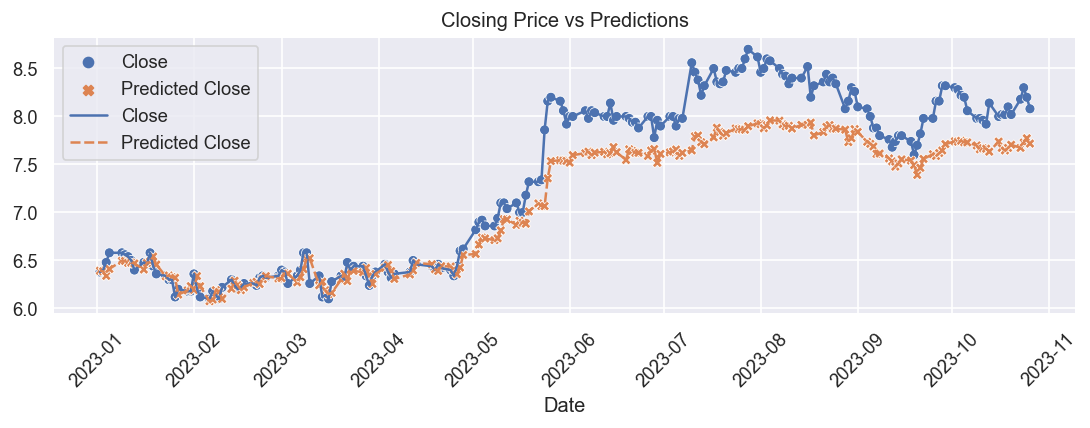

In [161]:
def build_lstm_default_model(train_set, test_set):
    
    from tensorflow import keras
    from sklearn.preprocessing import MinMaxScaler

    # Set a random seed
    np.random.seed(42)

    #scaling the data before modeling
    scaler = MinMaxScaler()
    scaled_array = scaler.fit_transform(train_set)
    train_data = pd.DataFrame(scaled_array, columns=train_set.columns, index=train_set.index)
    
    scaled_array = scaler.transform(test_set)
    test_data = pd.DataFrame(scaled_array, columns=test_set.columns, index=test_set.index)

    
    # Prepare the data for Random Forest
    X_train = train_data.drop(['target'], axis=1, inplace=False)
    y_train = train_data['target']

    X_test = test_data.drop(['target'], axis=1, inplace=False)
    y_test = test_data['target']
    
    
    # build the LSTM model
    lstm = keras.Sequential()
    lstm.add(keras.layers.LSTM(20, input_shape=(X_train.shape[1], 1)))
    lstm.add(keras.layers.Dense(1))
    
    # Compile the model
    lstm.compile(optimizer='adam', loss='mean_squared_error')
    
    # Train the Model
    lstm.fit(X_train, y_train, epochs=100, batch_size=7, verbose=0)

    # Make predictions using the trained model
    y_pred = lstm.predict(X_test)
    
    # unscale y_pred_diff
    train_data = train_set
    test_data = test_set
    y_pred = (y_pred * (train_data['Close'].max() - train_data['Close'].min())) + train_data['Close'].min()
    
    test_data["y_pred"] = y_pred
    
    
    # Calculate RMSE (Root Mean Squared Error) to evaluate the model's performance
    rmse = np.sqrt(mean_squared_error(test_data["target"], test_data["y_pred"]))
    print(f"RMSE: {rmse}")


    #plot Close and predicted Close price
    
    plot_df = pd.DataFrame({'Date': test_set.index,
                       'Close': test_set['target'],
                       'Predicted Close': test_set['y_pred']
                           })


    my_plot = sns.set(rc={'figure.figsize':(11, 3)})
    plt.figure()
    my_plot = sns.scatterplot(plot_df)
    my_plot = sns.lineplot(plot_df)
    my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45)
    my_plot.set(title='Closing Price vs Predictions')
    
    return lstm, rmse

lstm_model_default, lstm_model_default_rmse = build_lstm_default_model(train_set.copy(), test_set.copy())

# Save the model performance
df_default_model_rmse_performance.loc['LSTM'] = lstm_model_default_rmse

# 8-7-1 Build Default LSTM after finding the optimal lag / order

1/1 [==============================] - 2s 2s/step
RMSE: 0.13256632254992623


(<keras.engine.sequential.Sequential at 0x17d4f9871f0>, 0.13256632254992623)

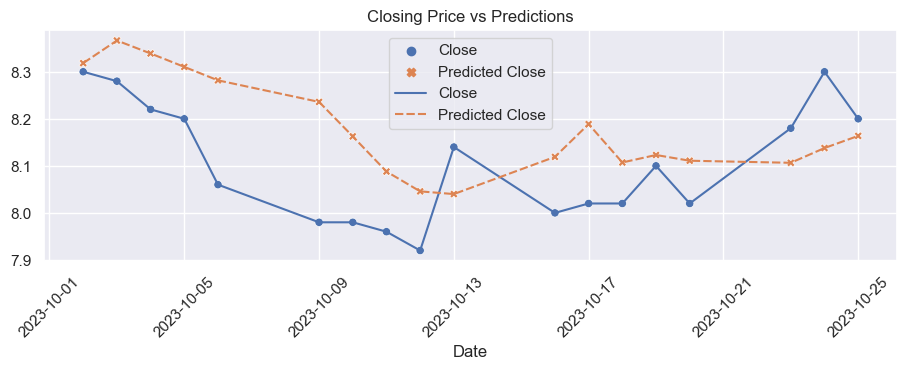

In [100]:
# build train/valid/test optimal lagged datasets for LSTM
lagged_train_set, lagged_validation_set, lagged_test_set = get_datasets_after_finding_best_lags(main_df.copy(), 
                                                                                                best_lag_period_lstm)

# build LSTM model with lagged values and default parameters
lstm_model_default_lagged, lstm_model_default_lagged_rmse = build_lstm_default_model(lagged_train_set.copy(), lagged_test_set.copy())


# Save the model performance
df_default_model_with_lagged_features_rmse_performance.loc['LSTM'] = lstm_model_default_lagged_rmse

# 8-7-1 Tuned LSTM

In [ ]:
def LSTM_tuning(train_set, validation_set, test_set):

    from hyperopt import hp, tpe, fmin, Trials, space_eval
    import keras
    from keras.models import Sequential
    from keras.layers import LSTM, Dense
    from sklearn.preprocessing import MinMaxScaler

    # Set a random seed
    ''' 
    By setting the random seed with np.random.seed(42), 
    you ensure that the random sampling in Hyperopt is reproducible across runs 
    as long as the seed remains the same.
    '''
    np.random.seed(42)

    # Define the search space for hyperparameters
    space = {
    'lstm_units': hp.choice('lstm_units', range(5, 51, 2)),
    'learning_rate': hp.quniform('learning_rate', 0.025, 0.5, 0.005),
    'batch_size': hp.choice('batch_size', range(8, 65, 4)),
    'epochs': hp.choice('epochs', range(10, 51, 5))
}

    # Define the objective function to minimize (negative mean squared error)
    def objective(params):

        #scaling the data before modeling
        scaler = MinMaxScaler()
        scaled_array = scaler.fit_transform(train_set)
        train_data = pd.DataFrame(scaled_array, columns=train_set.columns, index=train_set.index)
        
        scaled_array = scaler.transform(validation_set)
        validation_data = pd.DataFrame(scaled_array, columns=validation_set.columns, index=validation_set.index)

        
        # Prepare the data for Random Forest
        X_train = train_data.drop(['target'], axis=1, inplace=False)
        y_train = train_data['target']

        X_test = validation_data.drop(['target'], axis=1, inplace=False)
        y_test = validation_data['target']

        model = Sequential()
        model.add(LSTM(units=params['lstm_units'], input_shape=(X_train.shape[1], 1)))
        model.add(Dense(1))
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=params['learning_rate']), loss='mean_squared_error')
        model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], verbose=0)
        y_pred = model.predict(X_test)

        # unscale y_pred_diff
        train_data = train_set
        validation_data = validation_set
        y_pred = (y_pred * (train_data['Close'].max() - train_data['Close'].min())) + train_data['Close'].min()
        y_test = validation_data['target']

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        return rmse

    # Create an instance of the Trials class to keep track of the results
    trials = Trials()

    # Run the hyperparameter search using the TPE algorithm
    best = fmin(fn=objective,
                space=space,
                algo=tpe.suggest,
                max_evals=150,
                trials=trials,
                rstate=np.random.default_rng(42))


    # Get the best hyperparameters
    best_params = space_eval(space, best)
    print(best_params)

    # Train the final model with the best hyperparameters

    #scaling the data before modeling
    scaler = MinMaxScaler()
    scaled_array = scaler.fit_transform(train_set)
    train_data = pd.DataFrame(scaled_array, columns=train_set.columns, index=train_set.index)

    scaled_array = scaler.transform(test_set)
    test_data = pd.DataFrame(scaled_array, columns=test_set.columns, index=test_set.index)


    # Prepare the data for Random Forest
    X_train = train_data.drop(['target'], axis=1, inplace=False)
    y_train = train_data['target']

    X_test = test_data.drop(['target'], axis=1, inplace=False)
    y_test = test_data['target']


    final_model = Sequential()
    final_model.add(LSTM(units=best_params['lstm_units'], input_shape=(X_train.shape[1], 1)))
    final_model.add(Dense(1))
    final_model.compile(optimizer=keras.optimizers.Adam(learning_rate=best_params['learning_rate']), loss='mean_squared_error')
    final_model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)

    # Make predictions on the test set
    y_pred = final_model.predict(X_test)

    # unscale y_pred_diff
    train_data = train_set
    test_data = test_set
    y_pred = (y_pred * (train_data['Close'].max() - train_data['Close'].min())) + train_data['Close'].min()
    y_test = test_data['target']
    test_data["y_pred"] = y_pred

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print("{} rmse".format(rmse))


    #plot Close and predicted Close price
    plot_df = pd.DataFrame({'Date': test_data.index,
                       'Close': test_data['target'],
                       'Predicted Close': test_data["y_pred"]
                           })


    my_plot = sns.set(rc={'figure.figsize':(11, 3)})
    plt.figure()
    my_plot = sns.scatterplot(plot_df)
    my_plot = sns.lineplot(plot_df)
    my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45)
    my_plot.set(title='Closing Price vs Predictions')

    # Save the model performance and model's name
    df_model_performances.loc["LSTM_tuned"] = rmse

    return final_model, rmse

lstm_model_tuned, lstm_tuned_rmse = LSTM_tuning(train_set, validation_set, test_set)

# 9 Evaluate Models' performances

In [100]:
# default models and default dataset
df_default_model_rmse_performance = df_default_model_rmse_performance.sort_values(by='rmse')
print("default models and default dataset")
print(df_default_model_rmse_performance.sort_values(by='rmse'))
print()


# default models and optimal lagged dataset 
df_default_model_with_lagged_features_rmse_performance = df_default_model_with_lagged_features_rmse_performance.sort_values(by='rmse')
print("default models and optimal lagged dataset")
print(df_default_model_with_lagged_features_rmse_performance.sort_values(by='rmse'))
print()


# tuned models and optimal lagged dataset 
df_tuned_model_with_lagged_features_rmse_performance = df_tuned_model_with_lagged_features_rmse_performance.sort_values(by='rmse')
print("tuned models and optimal lagged dataset ")
print(df_tuned_model_with_lagged_features_rmse_performance.sort_values(by='rmse'))
print()


# Save the dataframes to CSV files
df_default_model_rmse_performance.to_csv('df_default_model_rmse_performance_exp1.0.csv', index=True)
df_default_model_with_lagged_features_rmse_performance.to_csv('df_default_model_with_lagged_rmse_performance_exp1.0.csv', index=True)
df_tuned_model_with_lagged_features_rmse_performance.to_csv('df_tuned_model_with_lagged_rmse_performance_exp1.0.csv', index=True)


default models and default dataset
             rmse
svm      0.092551
rf       0.108698
XGBoost  0.145740
kNN      0.152207
LSTM          NaN

default models and optimal lagged dataset
             rmse
svm      0.093673
rf       0.095216
XGBoost  0.139526
kNN      0.152207
Arima         NaN
VAR           NaN
LSTM          NaN

tuned models and optimal lagged dataset 
                   rmse
svm_tuned      0.091088
XGBoost_tuned  0.096442
rf_tuned       0.104324
kNN_tuned      0.166003
Arima               NaN
VAR                 NaN
LSTM_tuned          NaN



# 10 Save the models

In [ ]:
import pickle
import os


""" 
# directory we want to create
directory_path = '/models'

# Check if the directory already exists
if not os.path.exists(directory_path):
    # If it doesn't exist, create it
    os.makedirs(directory_path) 
"""


pickle.dump(arima_model, open('arima_model_tuned_exp_1.0.pkl', 'wb'))
pickle.dump(model_var_fitted, open('var_model_tuned_exp_1.0.pkl', 'wb'))

pickle.dump(knn_model_baseline, open('knn_model_baseline_exp_1.0.pkl', 'wb'))
pickle.dump(svm_model_baseline, open('svm_model_baseline_exp_1.0.pkl', 'wb'))
pickle.dump(xgb_model_baseline, open('xgb_model_baseline_exp_1.0.pkl', 'wb'))
pickle.dump(rf_model_baseline, open('rf_model_baseline_exp_1.0.pkl', 'wb'))

pickle.dump(knn_model_tuned, open('knn_model_tuned_exp_1.0.pkl', 'wb'))
pickle.dump(svm_model_tuned, open('svm_model_tuned_exp_1.0.pkl', 'wb'))
pickle.dump(xgb_model_tuned, open('xgb_model_tuned_exp_1.0.pkl', 'wb'))
pickle.dump(rf_model_tuned, open('rf_model_tuned_exp_1.0.pkl', 'wb'))

# 11 Create Experiment info file

In [ ]:
import os

def create_file_and_write_string_values(file_name, string_values):
  
  """Creates a file and writes the given string values inside.

  Args:
    file_name: The name of the file to create.
    string_values: A list of string values to write to the file.
  """

  # If the file exists, delete it.
  if os.path.exists(file_name):
    os.remove(file_name)

  # Open the file for writing.
  with open(file_name, "w") as f:
    for string_value in string_values:
      f.write(string_value + "\n")


create_file_and_write_string_values("exp1.0-timestamps.txt", 
                                    ["train_start_time:", train_start_time, 
                                     "train_end_time:", train_end_time, 
                                     "validation_start_time:", validation_start_time, 
                                     "validation_end_time:", validation_end_time, 
                                     "test_start_time:", test_start_time])